In [1]:
# @title 連接google drive
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi
import os

os.chdir('/content/drive/My Drive')
os.getcwd()
os.chdir('/content/drive/My Drive/碳數據科技黑客松/總決賽/地圖模擬/filter_data')
os.getcwd()

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found


'/content/drive/My Drive/碳數據科技黑客松/總決賽/地圖模擬/filter_data'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm

In [3]:

df = pd.read_csv("filename2.csv")
print(df)
print(df.info())
# df.describe(include="all")
print("object行:\n",df.select_dtypes(include="object").columns)
print("缺失值:\n",df.isnull().sum())
print("唯一值:\n",df[:].nunique())

            ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0      0x4607     INDORES13DEL02                   37                     4.9   
1      0xb379     BANGRES18DEL02                   34                     4.5   
2      0x5d6d     BANGRES19DEL01                   23                     4.4   
3      0x7a6a    COIMBRES13DEL02                   38                     4.7   
4      0x70a2     CHENRES12DEL01                   32                     4.6   
...        ...                ...                 ...                     ...   
45588  0x7c09      JAPRES04DEL01                   30                     4.8   
45589  0xd641      AGRRES16DEL01                   21                     4.6   
45590  0x4f8d     CHENRES08DEL03                   30                     4.9   
45591  0x5eee    COIMBRES11DEL01                   20                     4.7   
45592  0x5fb2   RANCHIRES09DEL02                   23                     4.9   

       Restaurant_latitude 

In [ ]:
df['Route']

0        [[22.74505, 75.89247], [22.74507, 75.89248], [...
1        [[12.9131, 77.68297], [12.91196, 77.68272], [1...
2        [[12.91427, 77.67837], [12.91384, 77.67825], [...
3        [[11.00363, 76.97597], [11.00486, 76.97588], [...
4        [[12.97279, 80.25], [12.97335, 80.25014], [12....
                               ...                        
45587    [[23.37123, 85.32791], [23.37124, 85.32794], [...
45588    [[26.90241, 75.79427], [26.90241, 75.79424], [...
45590    [[13.02239, 80.24246], [13.02255, 80.24251], [...
45591    [[11.00189, 76.98621], [11.00168, 76.98531], [...
45592    [[23.35097, 85.32579], [23.35088, 85.32564], [...
Name: Route, Length: 40309, dtype: object

In [4]:
df.replace('NaN ', pd.NA, inplace=True)
df = df.dropna(subset=['Distance_km'])
df.dropna(subset=['Distance_km'], inplace=True)
columns = ['Order_Date', 'Time_Orderd']  # Specify the columns to check for NaN values
df = df.dropna(subset=columns)
print("缺失值:\n",df.isnull().sum())
print(df.info())

<ipython-input-4-d75117b419ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Distance_km'], inplace=True)


缺失值:
 ID                                0
Delivery_person_ID                0
Delivery_person_Age             200
Delivery_person_Ratings         242
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                       0
Time_Order_picked                 0
Weatherconditions                 0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             855
Festival                        206
City                           1059
Time_taken(min)                   0
Distance_km                       0
Route                             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40309 entries, 0 to 45592
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------           

In [ ]:
# 重置 df 的索引
df.reset_index(drop=True, inplace=True)

# 重新计算 over_1000_indices
over_1000_indices = df[df['Distance_km'] > 1000].index

# 检查指定列中的值是否小于 0，如果是，则乘以 -1
columns_to_check = ['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']
for col in columns_to_check:
    df.loc[over_1000_indices, col] = df.loc[over_1000_indices, col].apply(lambda x: x * -1 if x < 0 else x)

# 尝试再次访问这些行
df_valid = df.iloc[over_1000_indices]

In [ ]:
len(over_1000_indices)
# df.iloc[over_1000_indices,'distance']
df.iloc[over_1000_indices]
print(over_1000_indices)
# print(df.shape)
# print("缺失值:\n",df.isnull().sum())

Int64Index([   80,   253,   959,  1559,  1845,  1935,  2019,  2307,  2446,
             2545,
            ...
            34851, 35383, 35839, 35860, 36381, 38586, 38771, 38939, 39720,
            39941],
           dtype='int64', length=112)


In [ ]:

def get_route_distance(lat1, lon1, lat2, lon2):
    # 构建请求URL
    url = f"http://router.project-osrm.org/route/v1/car/{lon1},{lat1};{lon2},{lat2}?overview=false"

    # 发送请求
    response = requests.get(url)

    # 解析JSON数据
    data = response.json()

    # 检查是否有 'routes' 键
    if 'routes' in data and len(data['routes']) > 0:
        # 返回路径的距离，转换成公里
        return data['routes'][0]['distance'] / 1000
    else:
        # 没有找到有效路径，返回 None 或适当的错误信息
        return None

# 初始化 tqdm 对 pandas apply 方法的支持
tqdm.pandas(desc="计算距离")
# 使用 progress_apply 计算距离
distances = df.iloc[over_1000_indices].progress_apply(
    lambda x: get_route_distance(
        x['Restaurant_latitude'],
        x['Restaurant_longitude'],
        x['Delivery_location_latitude'],
        x['Delivery_location_longitude']
    ), axis=1
)

# 更新 df 的 'distance' 列
df.loc[over_1000_indices, 'Distance_km'] = distances

print(df)


计算距离: 100%|██████████| 112/112 [00:55<00:00,  2.01it/s]

            ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0      0x4607     INDORES13DEL02                   37                     4.9   
1      0xb379     BANGRES18DEL02                   34                     4.5   
2      0x5d6d     BANGRES19DEL01                   23                     4.4   
3      0x7a6a    COIMBRES13DEL02                   38                     4.7   
4      0x70a2     CHENRES12DEL01                   32                     4.6   
...        ...                ...                 ...                     ...   
40304  0x1178   RANCHIRES16DEL01                   35                     4.2   
40305  0x7c09      JAPRES04DEL01                   30                     4.8   
40306  0x4f8d     CHENRES08DEL03                   30                     4.9   
40307  0x5eee    COIMBRES11DEL01                   20                     4.7   
40308  0x5fb2   RANCHIRES09DEL02                   23                     4.9   

       Restaurant_latitude 

In [ ]:

import requests
!pip install polyline
import polyline

def get_route(lat1, lon1, lat2, lon2):
    # Construct request URL
    url = f"http://router.project-osrm.org/route/v1/driving/{lon1},{lat1};{lon2},{lat2}?overview=full"

    # Send request
    response = requests.get(url)

    # Parse JSON data
    data = response.json()

    # Check if the 'routes' key exists in the JSON response
    if 'routes' in data and len(data['routes']) > 0:
        # Decode Polyline
        route_polyline = data['routes'][0]['geometry']
        route = polyline.decode(route_polyline)

        # Transform coordinates format if necessary
        route = [[lat, lon] for lat, lon in route]

        return route
    else:
        # Return an empty list or None if no route is found, or handle the error as needed
        return None

from tqdm import tqdm
tqdm.pandas(desc="Calculating routes")
route = df.iloc[over_1000_indices].progress_apply(
    lambda x: get_route(
        x['Restaurant_latitude'],
        x['Restaurant_longitude'],
        x['Delivery_location_latitude'],
        x['Delivery_location_longitude']
    ), axis=1
)

# 更新 df 的 'distance' 列
df.loc[over_1000_indices, 'Route'] = route

# Apply the function to the first 100 rows in the DataFrame to create a new 'Route' column
# df['Route'] = df.loc[over_1000_indices].progress_apply(lambda x: get_route(x['Restaurant_latitude'], x['Restaurant_longitude'], x['Delivery_location_latitude'], x['Delivery_location_longitude']), axis=1)

df.to_csv('/content/drive/My Drive/碳數據科技黑客松/總決賽/地圖模擬/filter_data/file_fi2.csv', index=False)

Calculating routes: 100%|██████████| 112/112 [00:55<00:00,  2.01it/s]


In [ ]:
df[df['Distance_km'] > 100].value_counts(),df['Distance_km'],df['Route']

(ID       Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  Delivery_location_longitude  Order_Date  Time_Orderd  Time_Order_picked  Weatherconditions      Road_traffic_density  Vehicle_condition  Type_of_order  Type_of_vehicle    multiple_deliveries  Festival  City            Time_taken(min)  Distance_km  Route                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

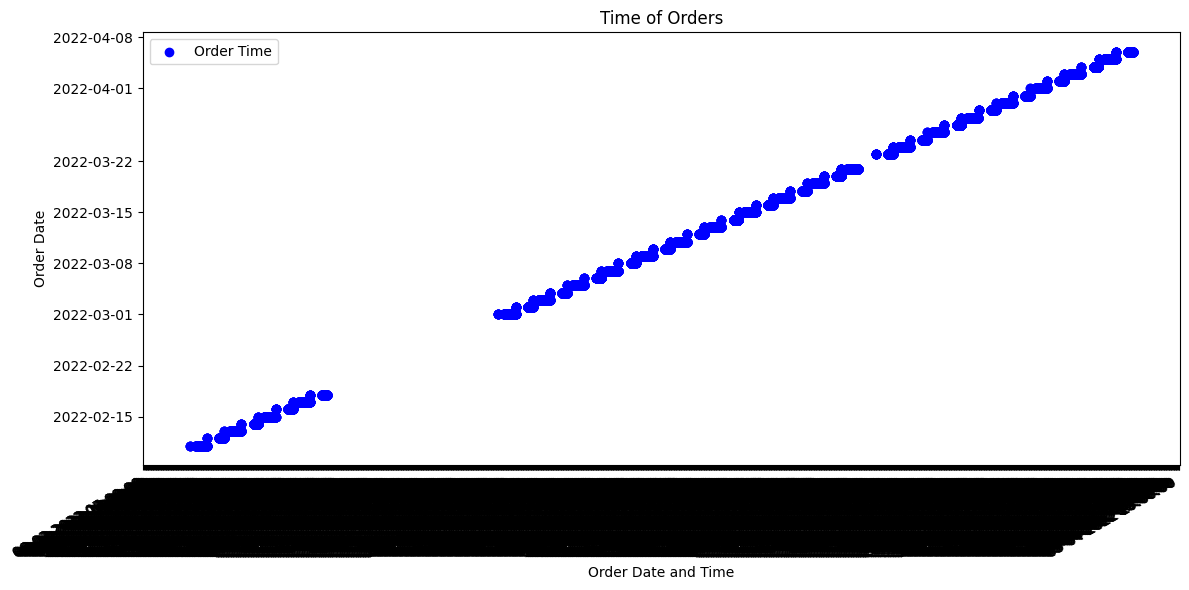

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# For demonstration, let's create a sample DataFrame with similar structure and data

df_sample = df

# Convert 'Order_Date' and 'Time_Orderd' to datetime objects
df_sample['Order_Date'] = pd.to_datetime(df_sample['Order_Date'], format='%d-%m-%Y')
df_sample['Time_Orderd'] = pd.to_datetime(df_sample['Time_Orderd'], format='%H:%M:%S').dt.time

# Plotting
plt.figure(figsize=(12, 6))

# We need to combine date and time into a single datetime object for plotting
combined_datetime = [datetime.combine(date, time) for date, time in zip(df_sample['Order_Date'], df_sample['Time_Orderd'])]

plt.scatter(combined_datetime, df_sample['Order_Date'].dt.date, c='blue', label='Order Time')
plt.gcf().autofmt_xdate()  # Automatically format x-axis labels to fit the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M:%S'))  # Set formatter for x-axis to show date and time
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set locator to show an interval of 1 hour
plt.xlabel('Order Date and Time')
plt.ylabel('Order Date')
plt.title('Time of Orders')
plt.legend()
plt.tight_layout()

plt.show()


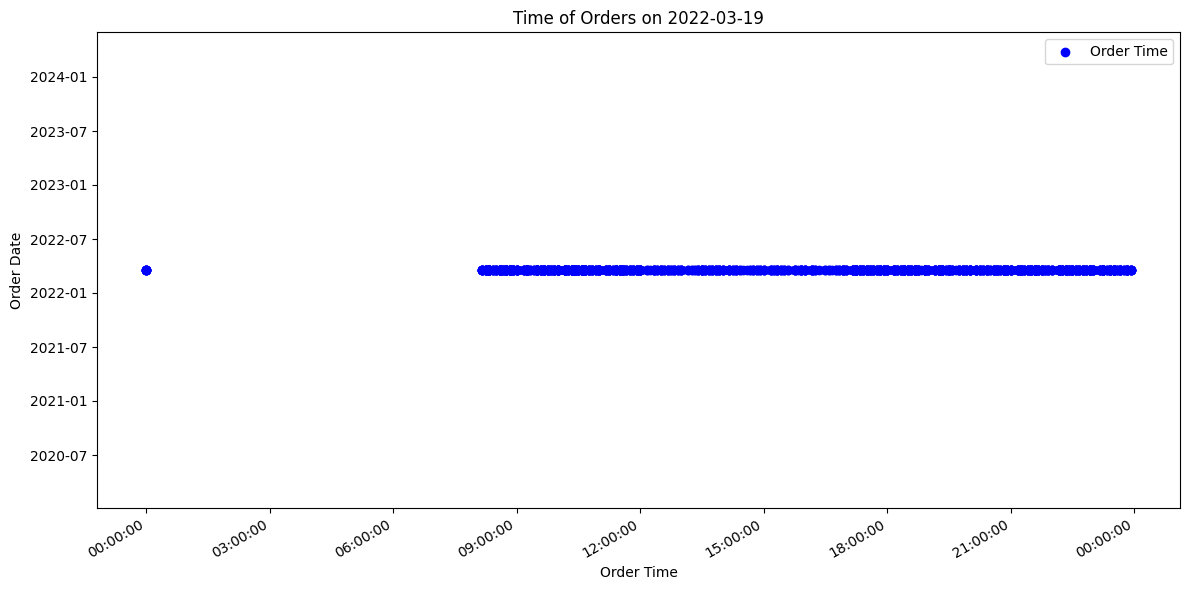

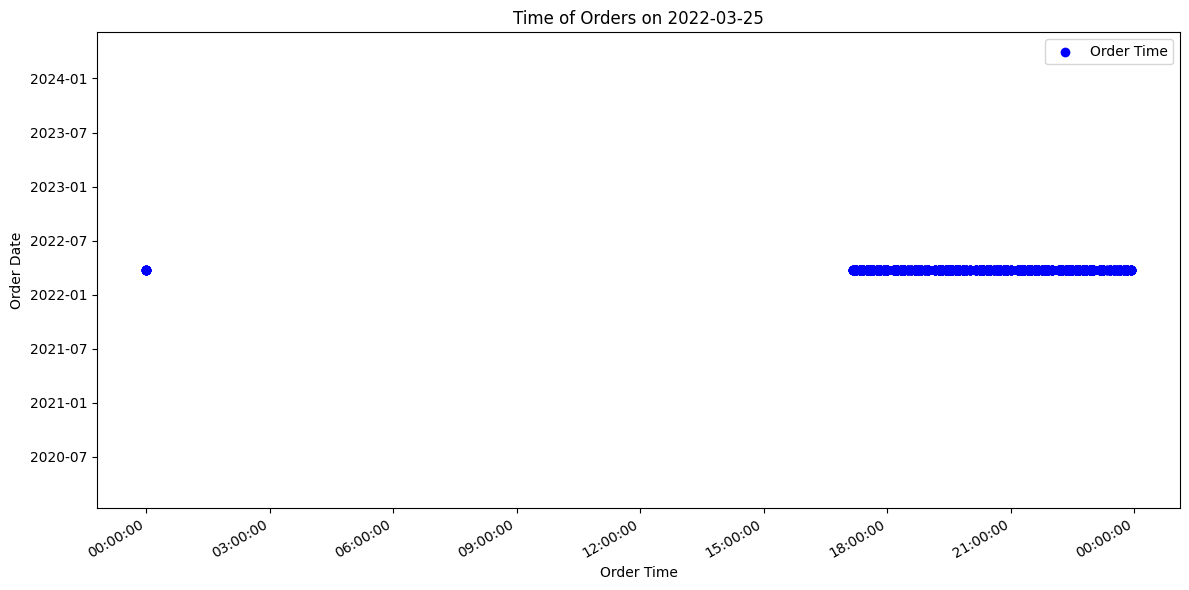

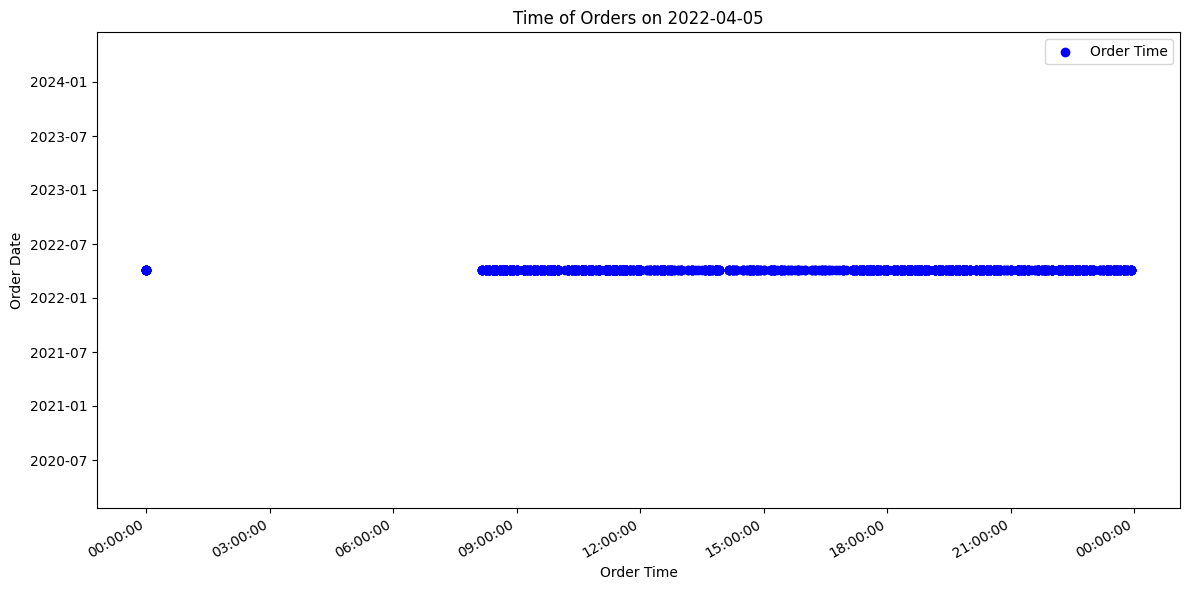

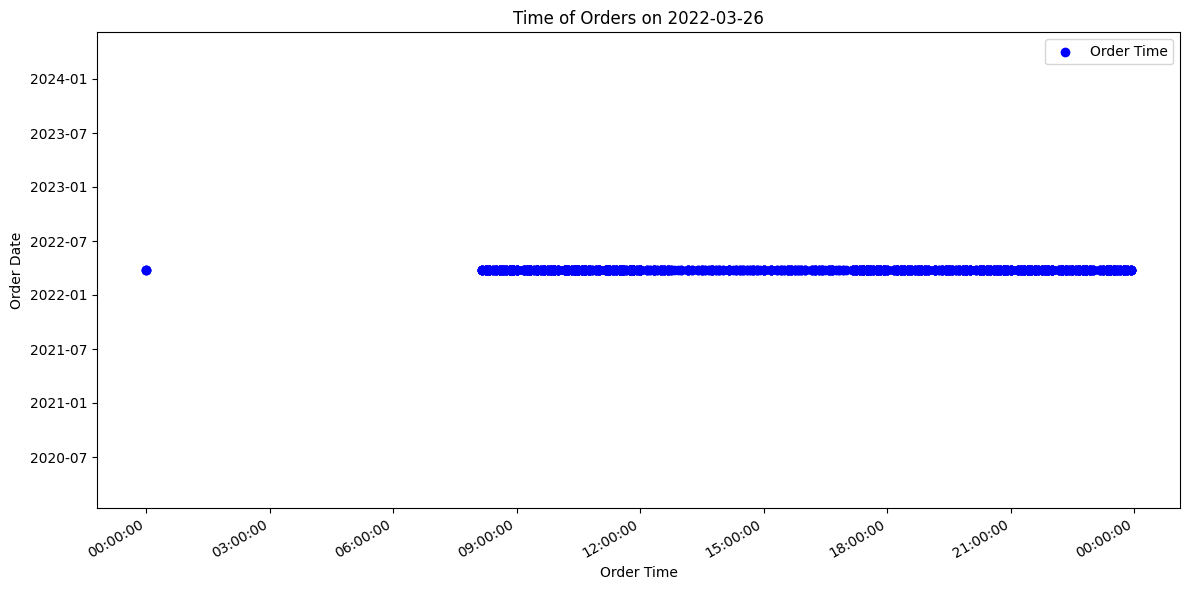

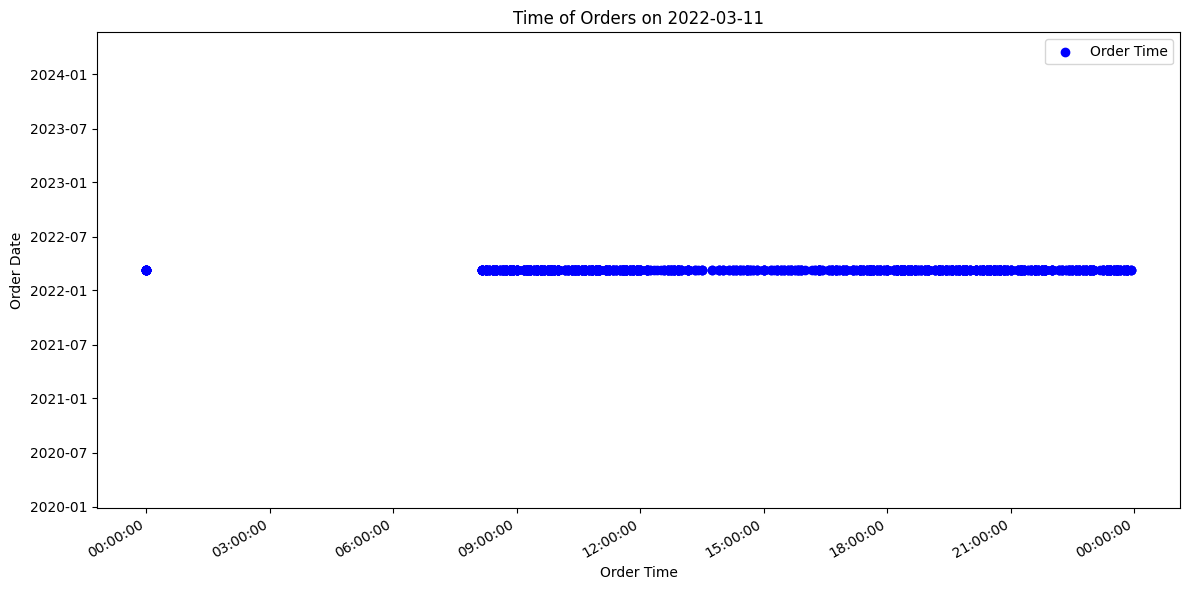

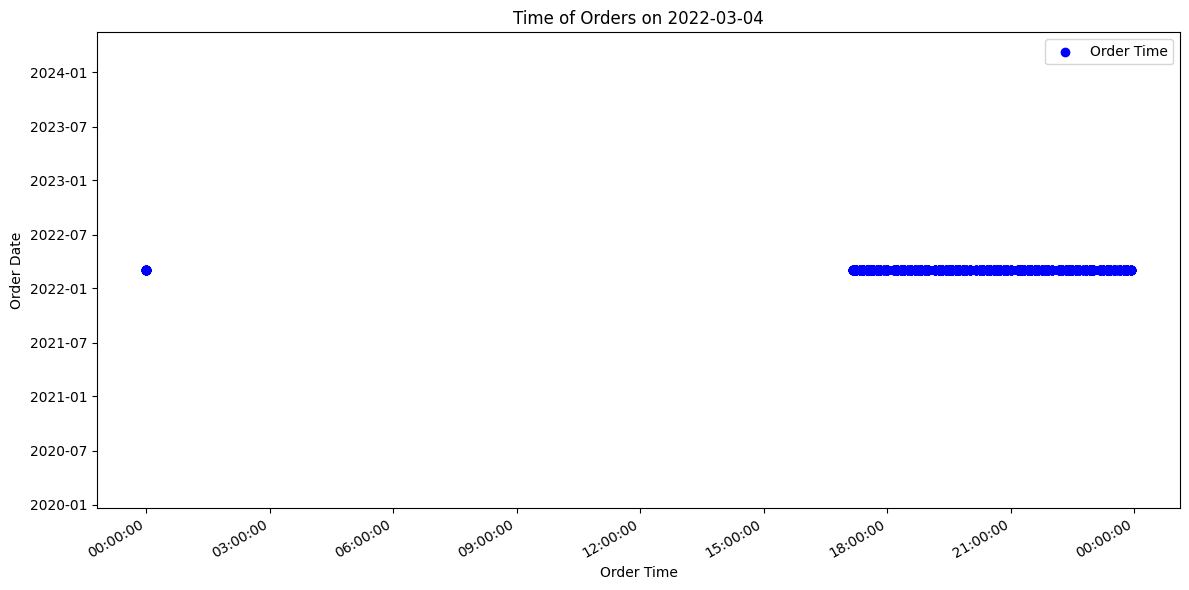

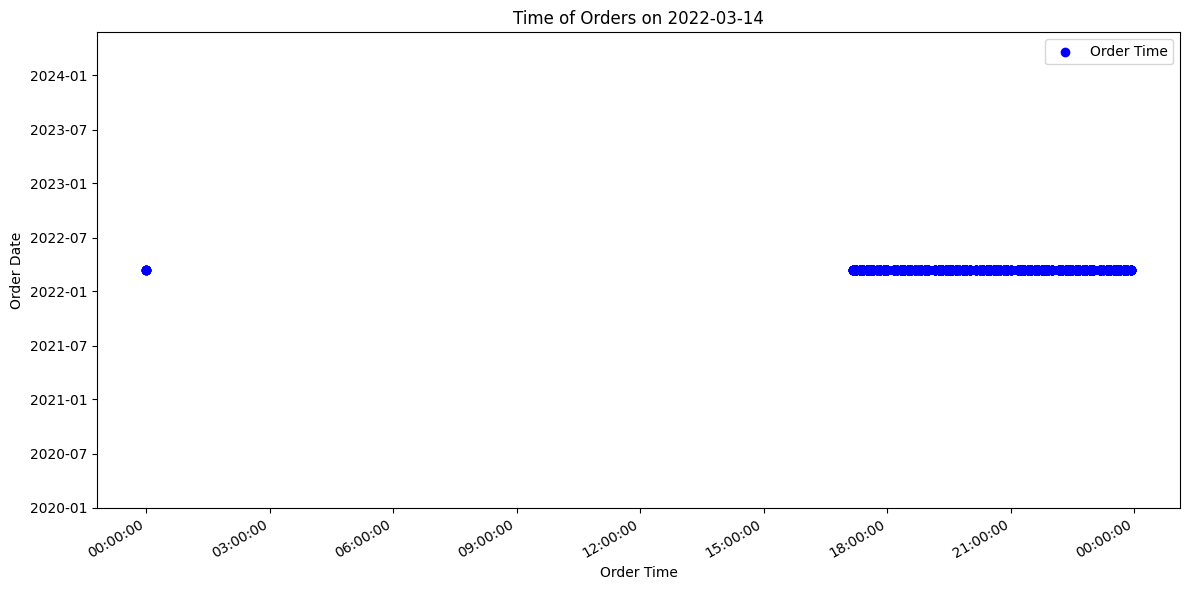

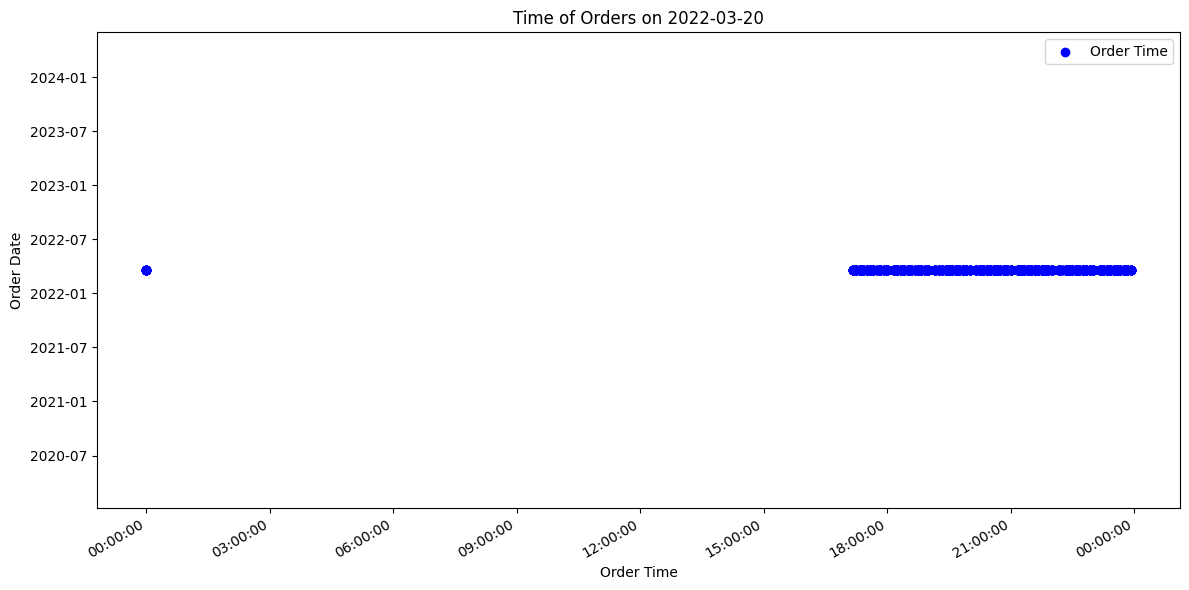

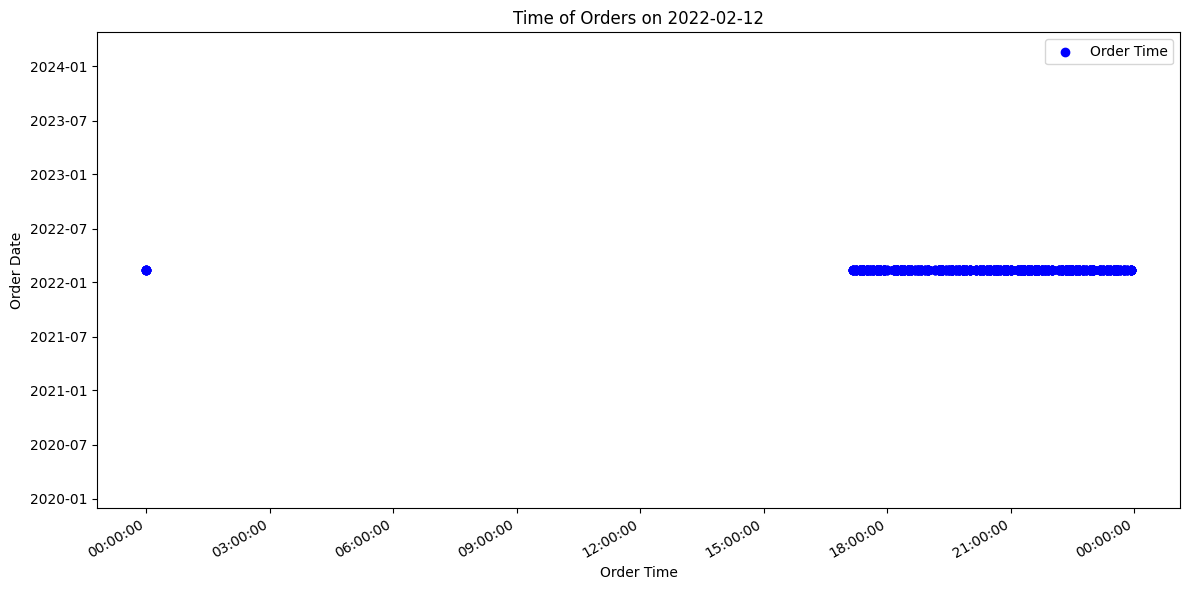

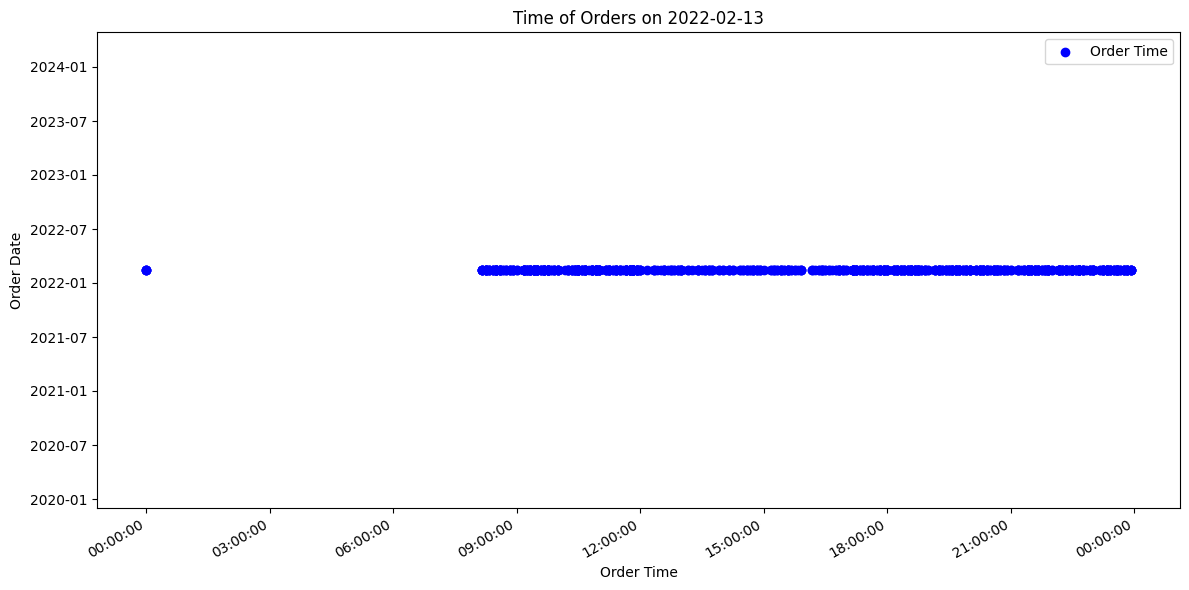

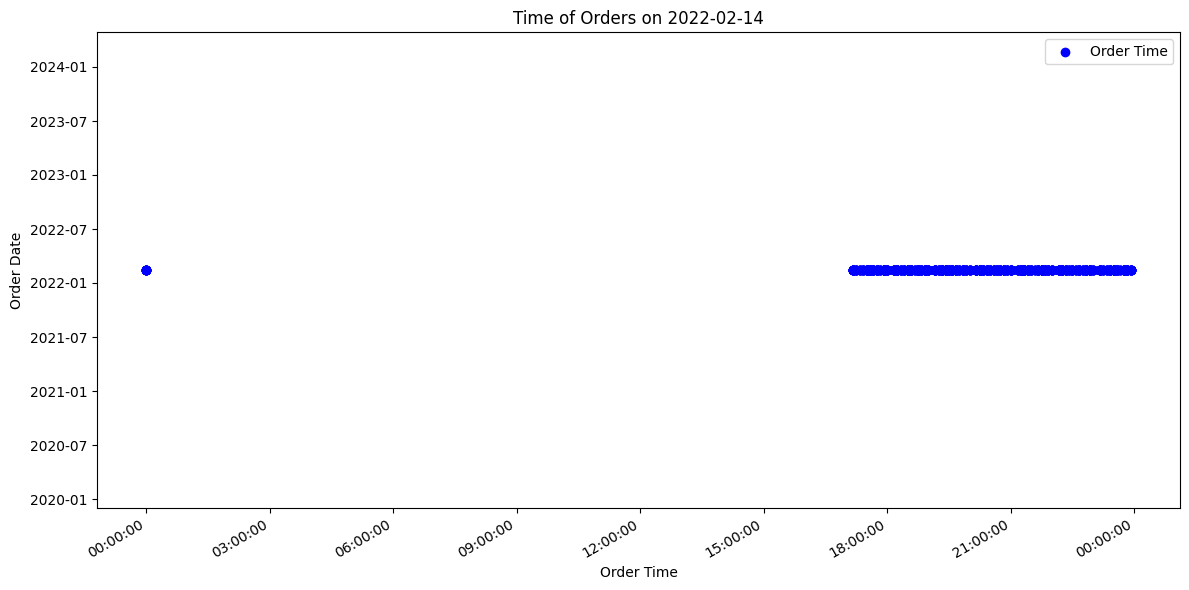

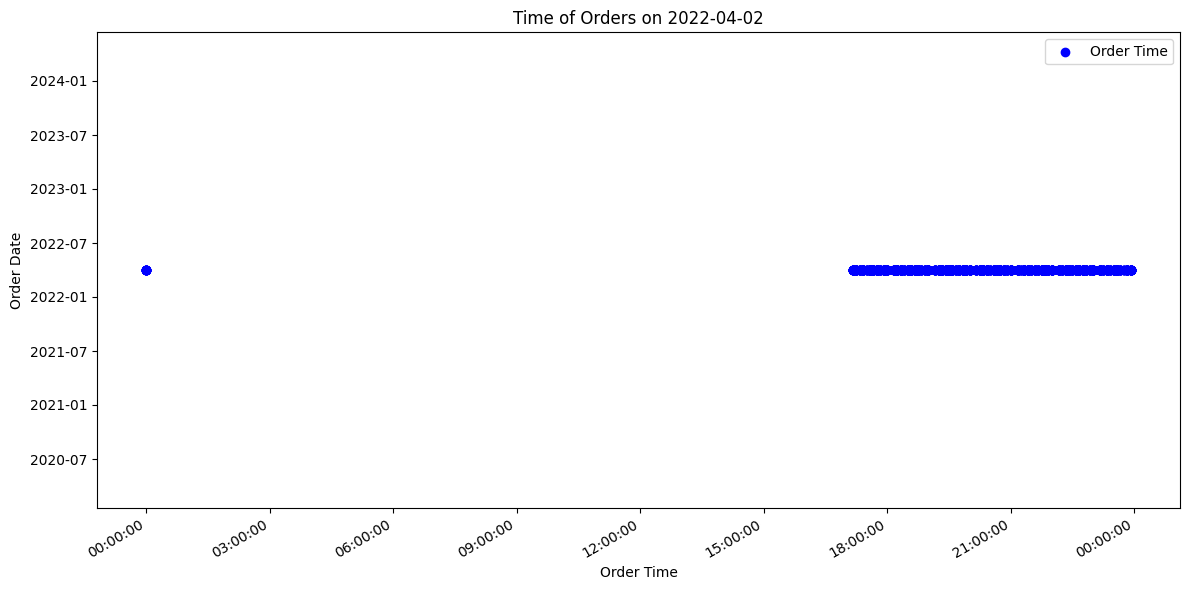

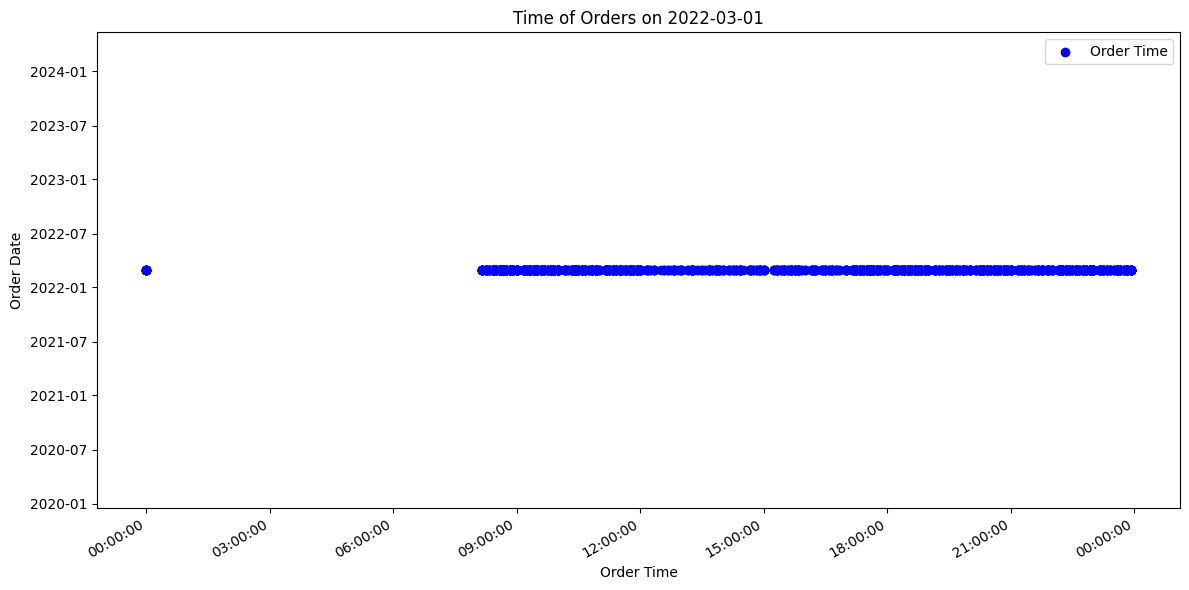

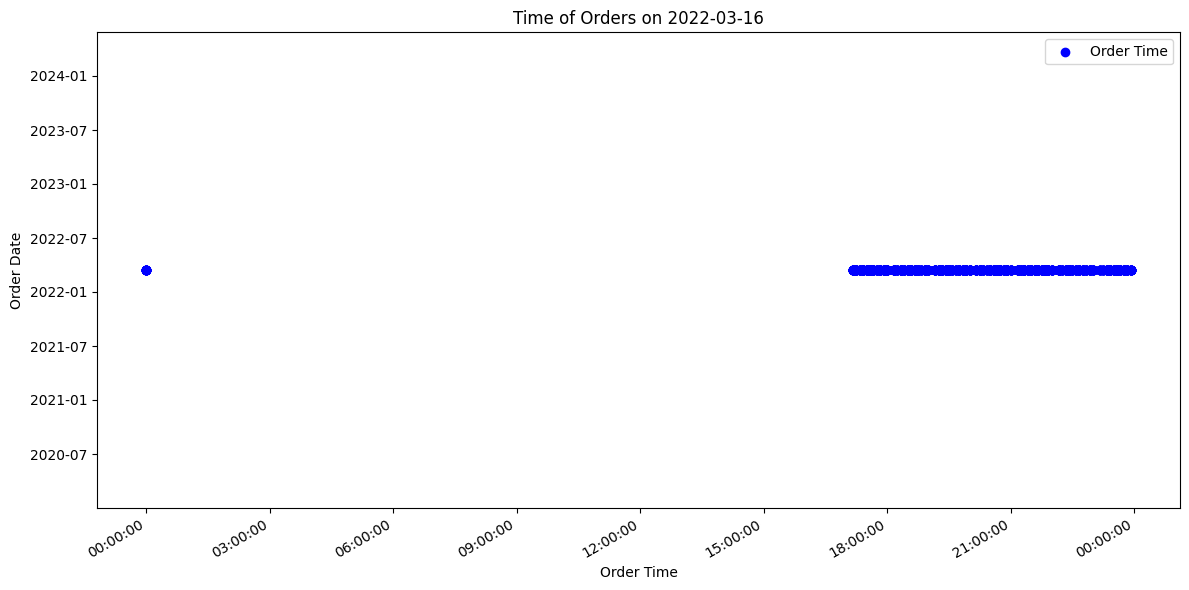

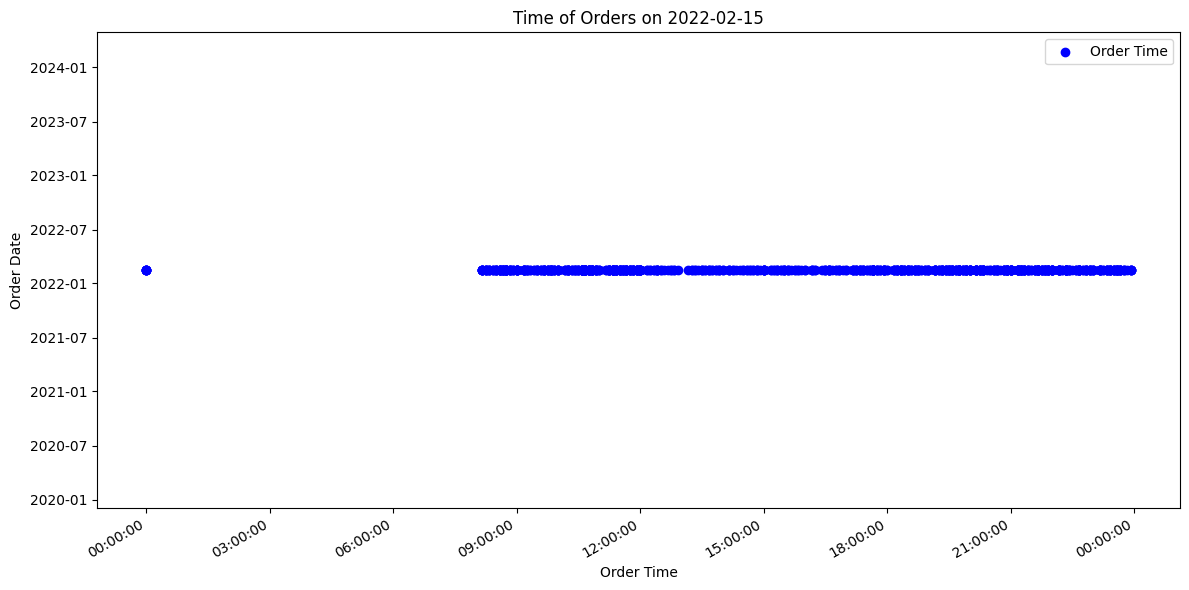

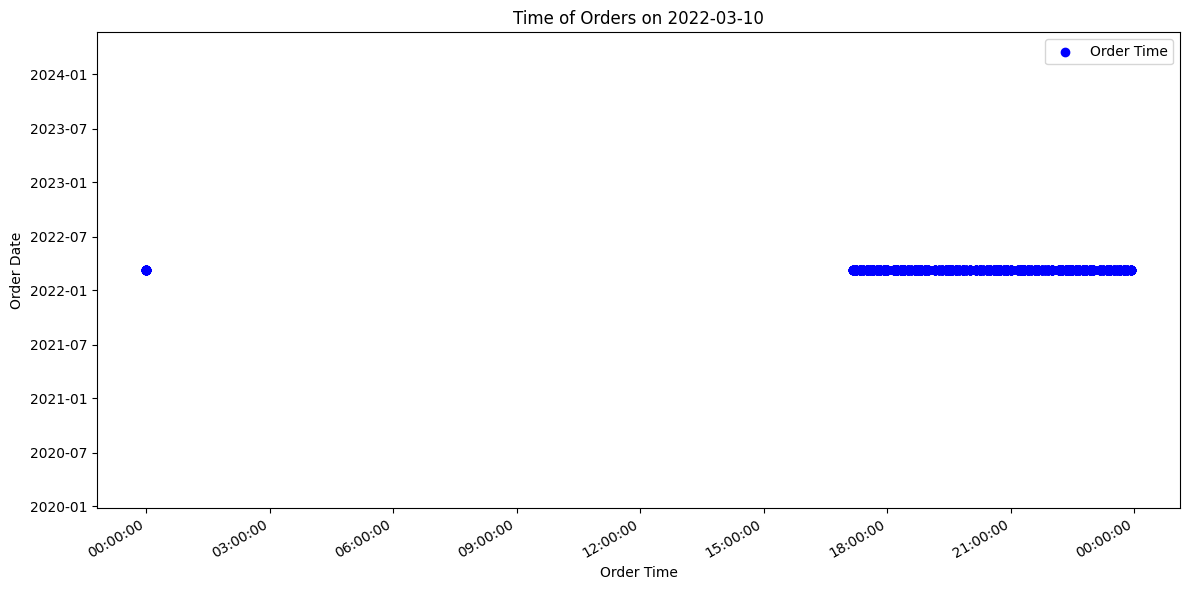

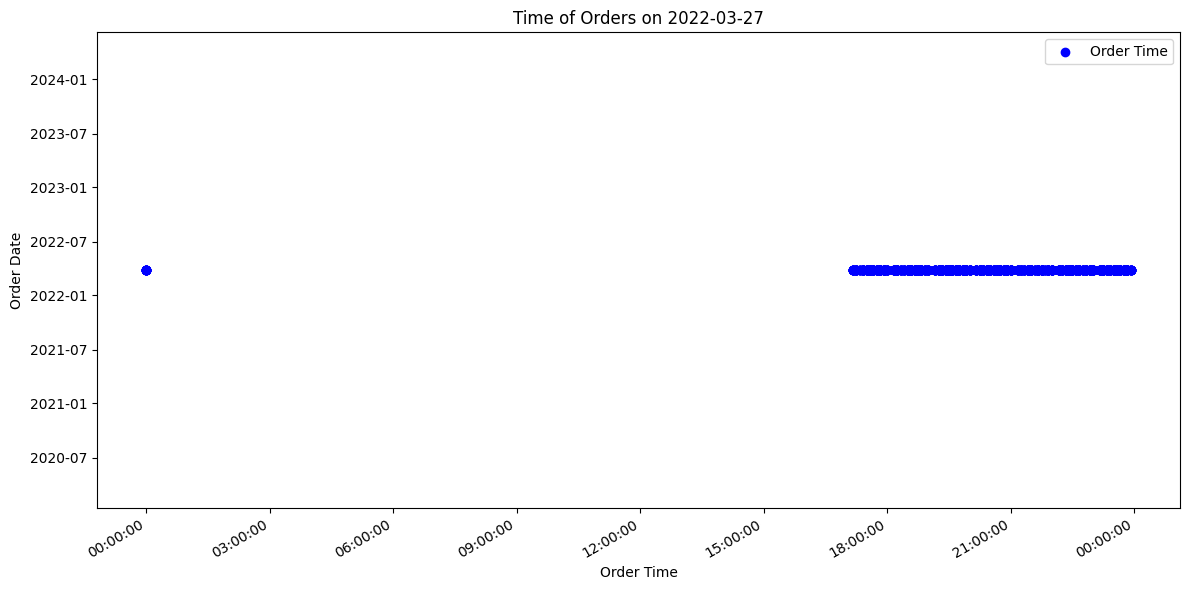

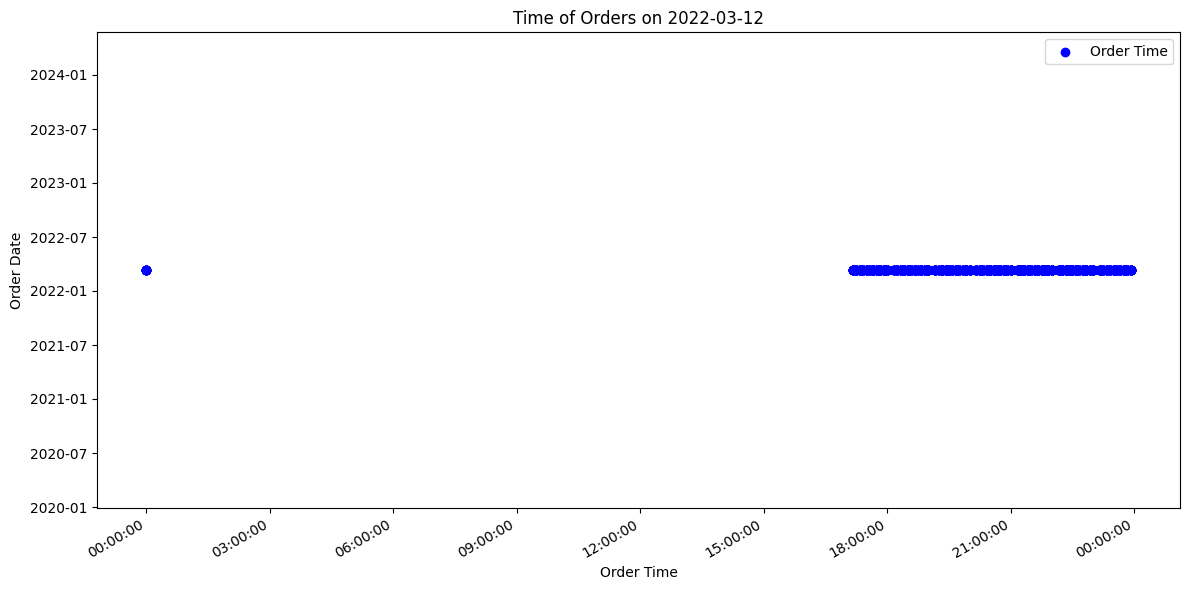

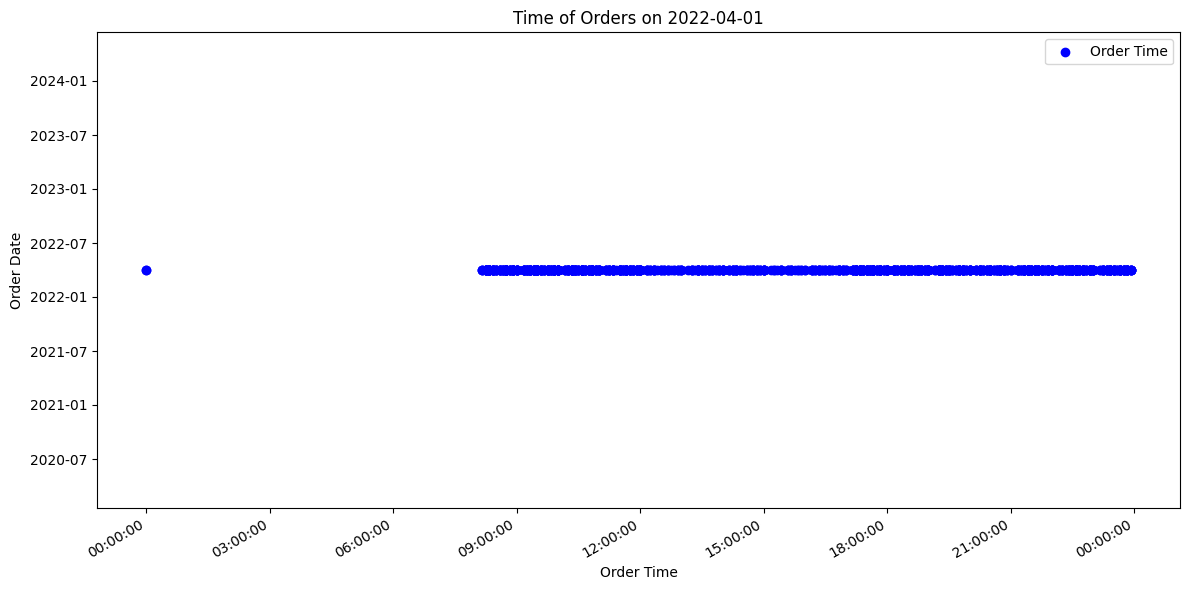

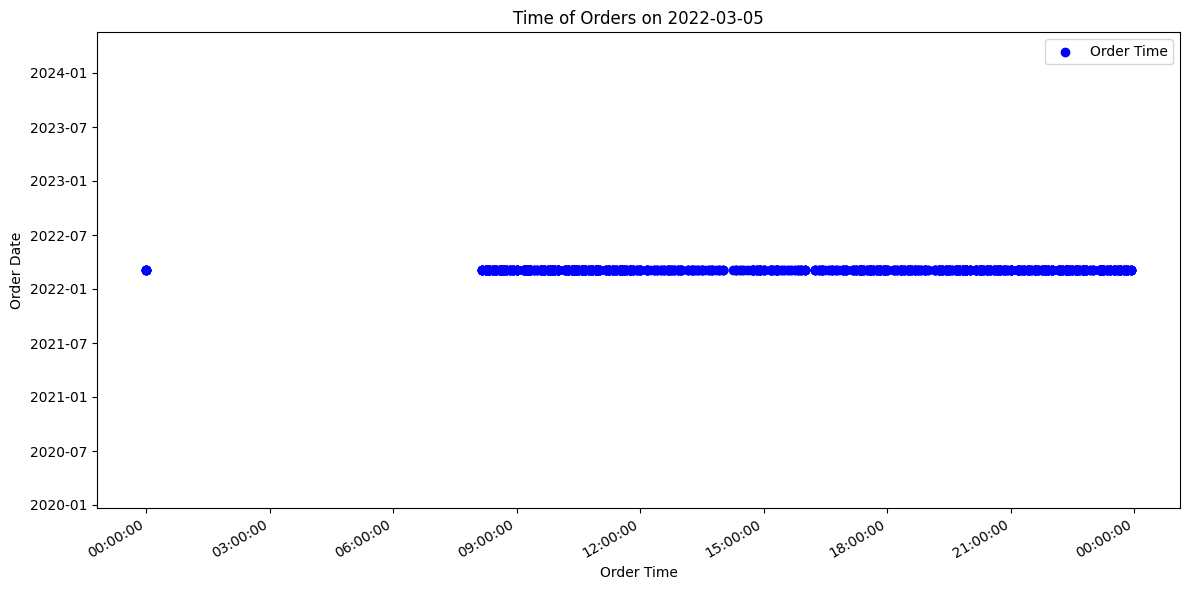

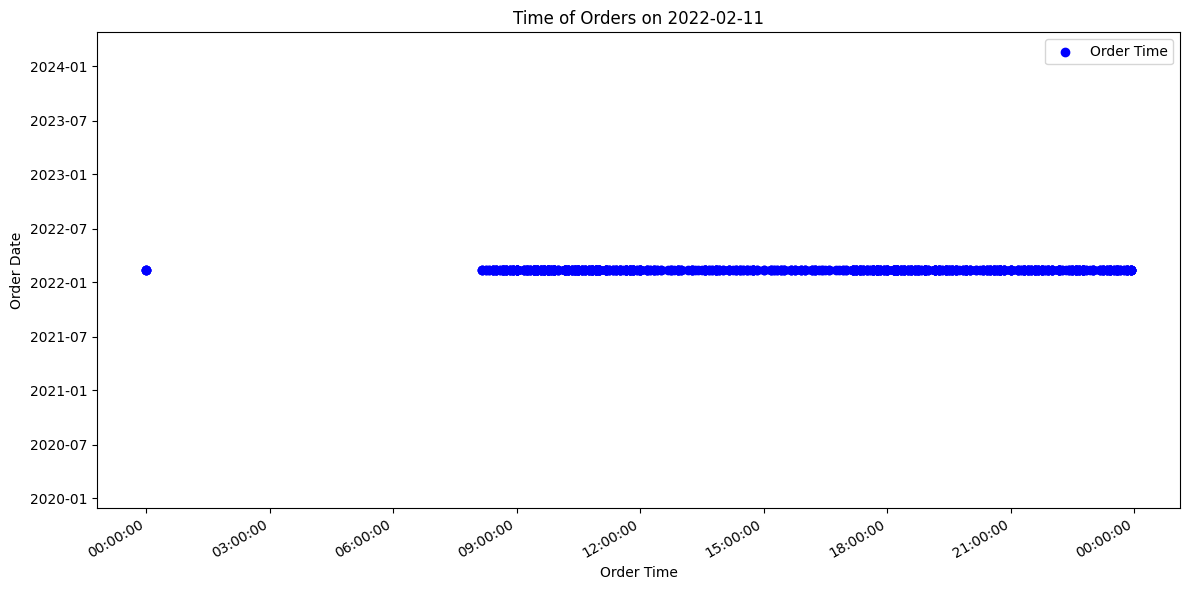

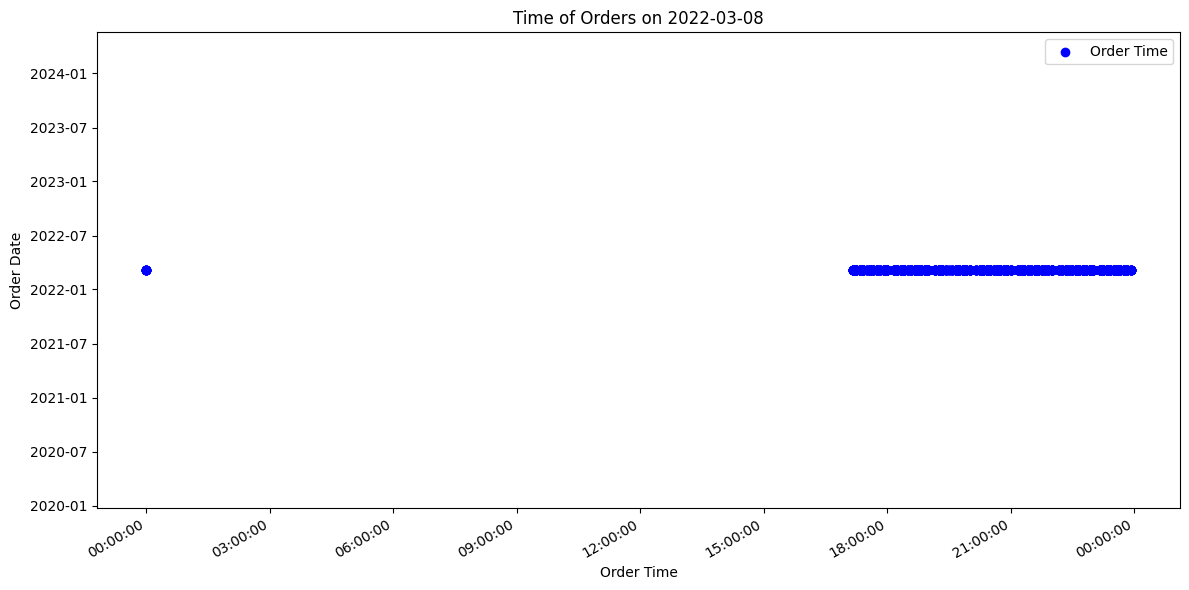

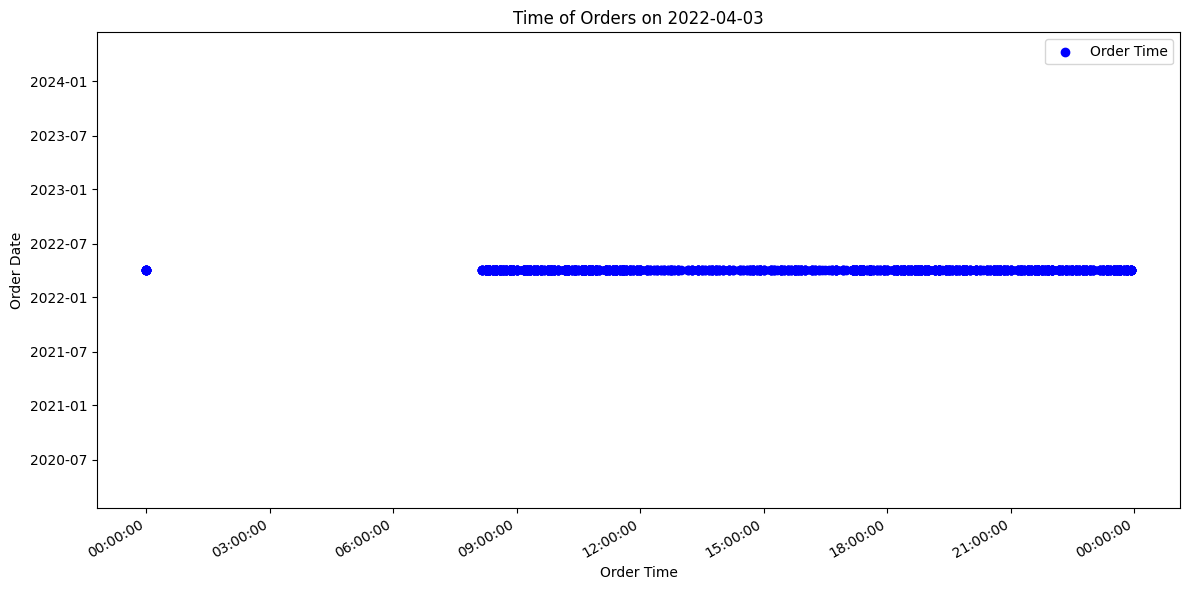

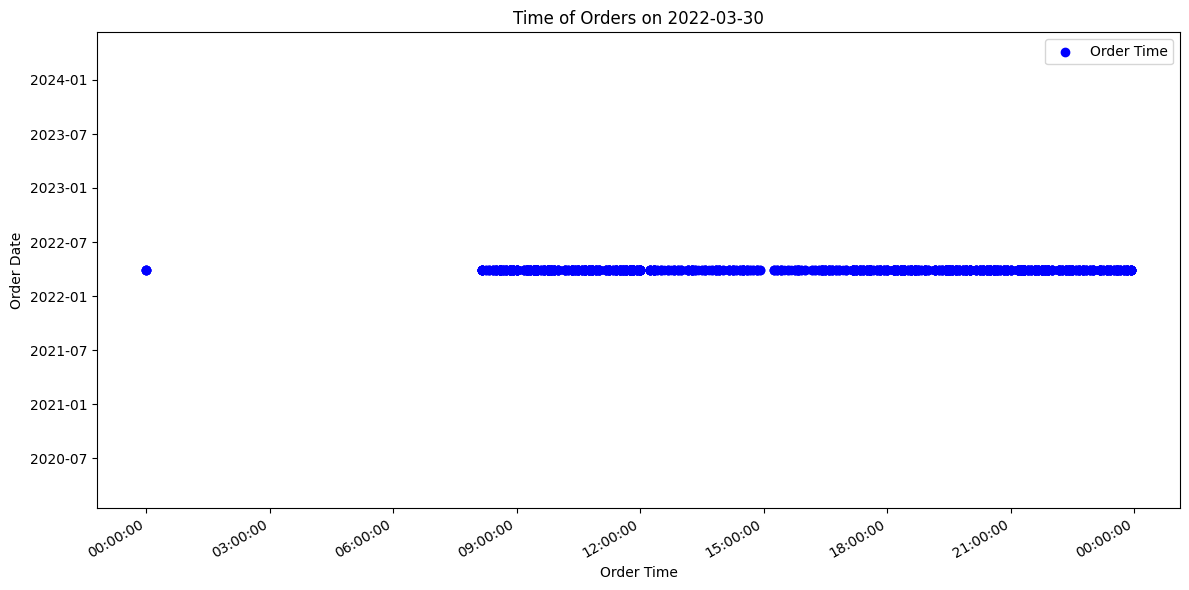

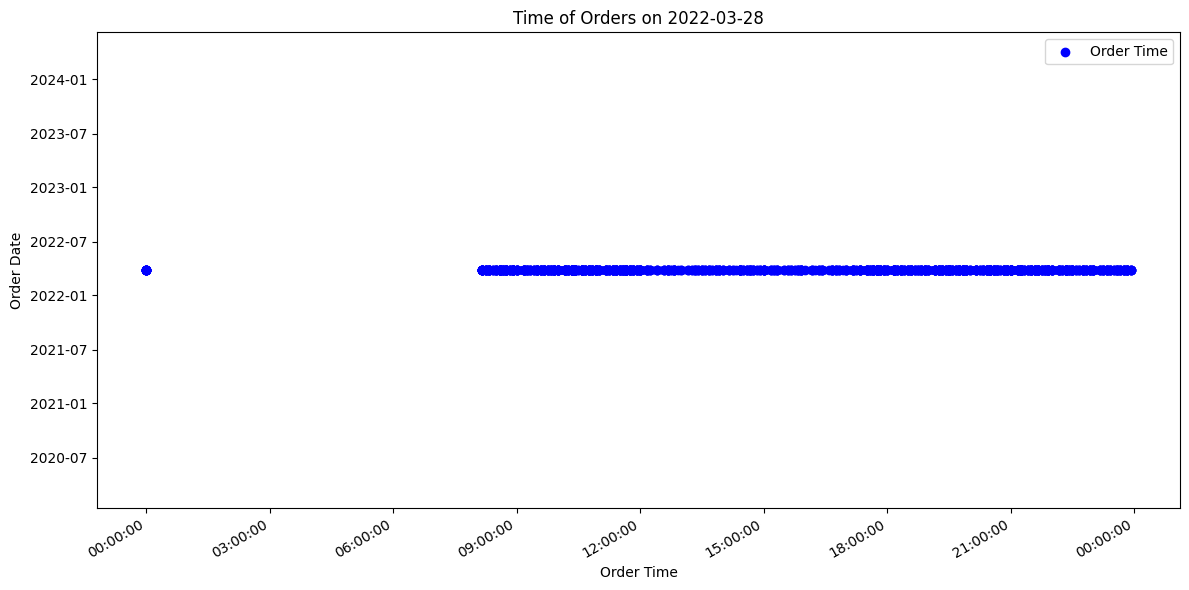

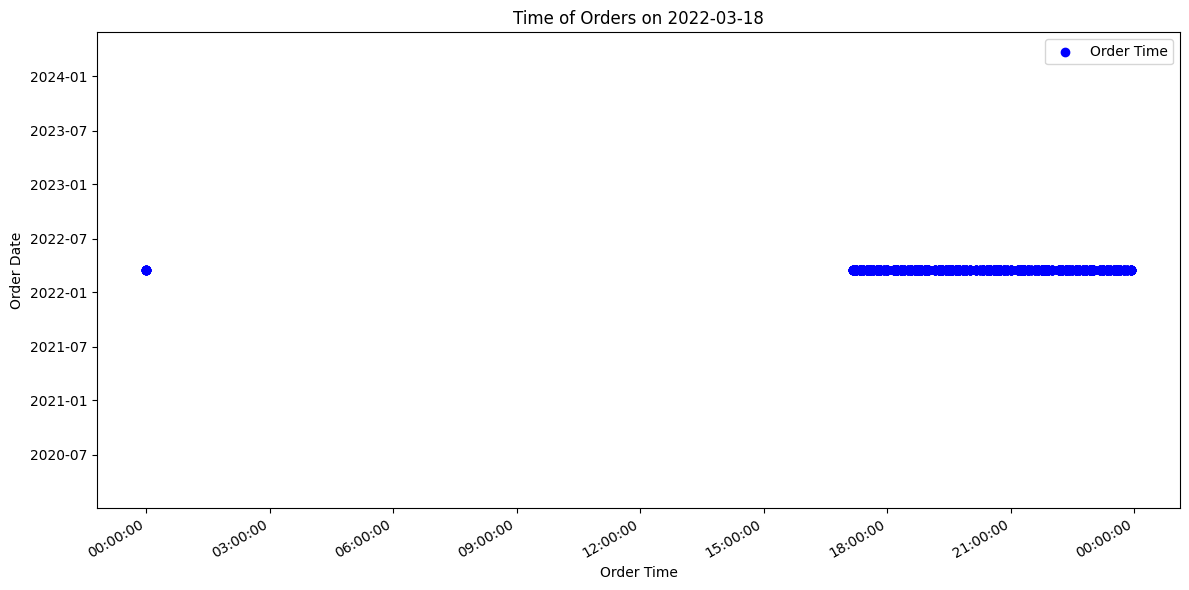

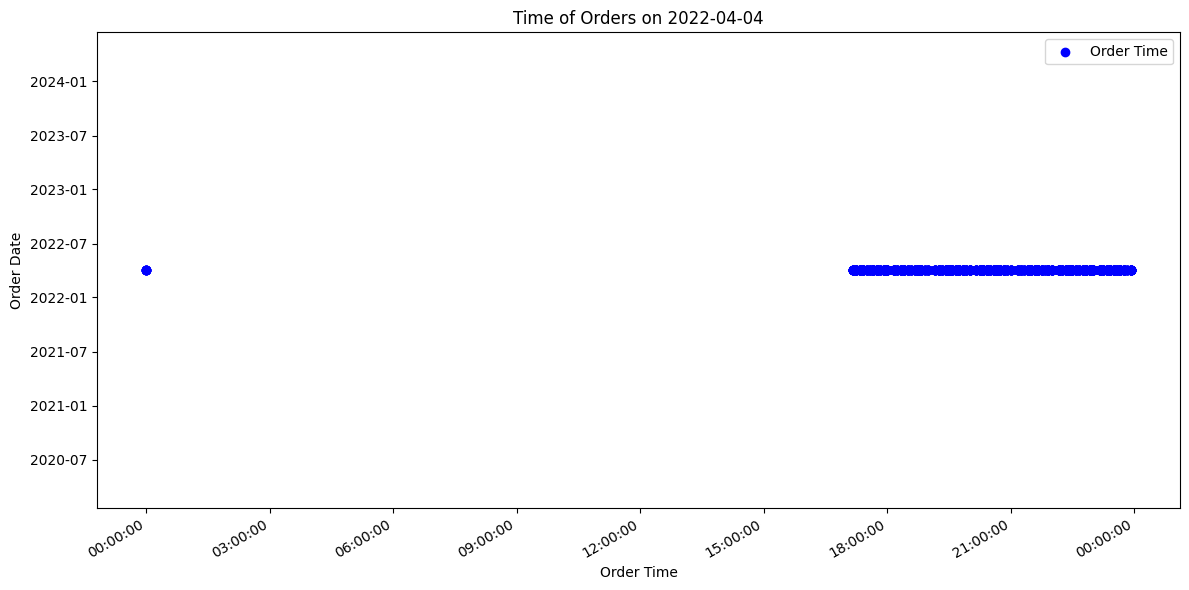

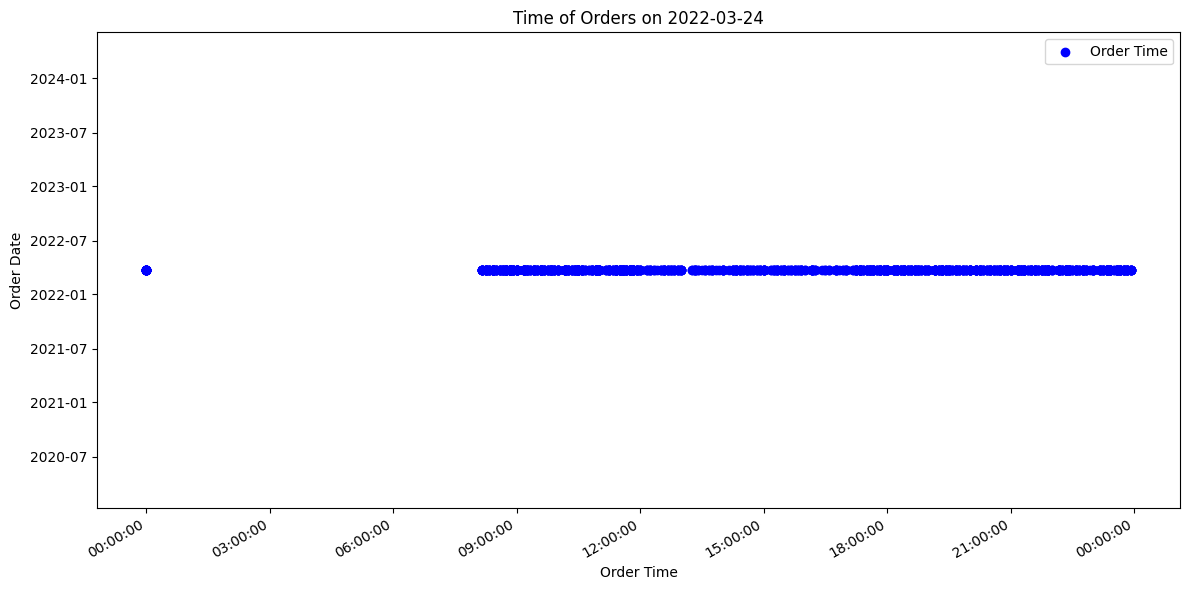

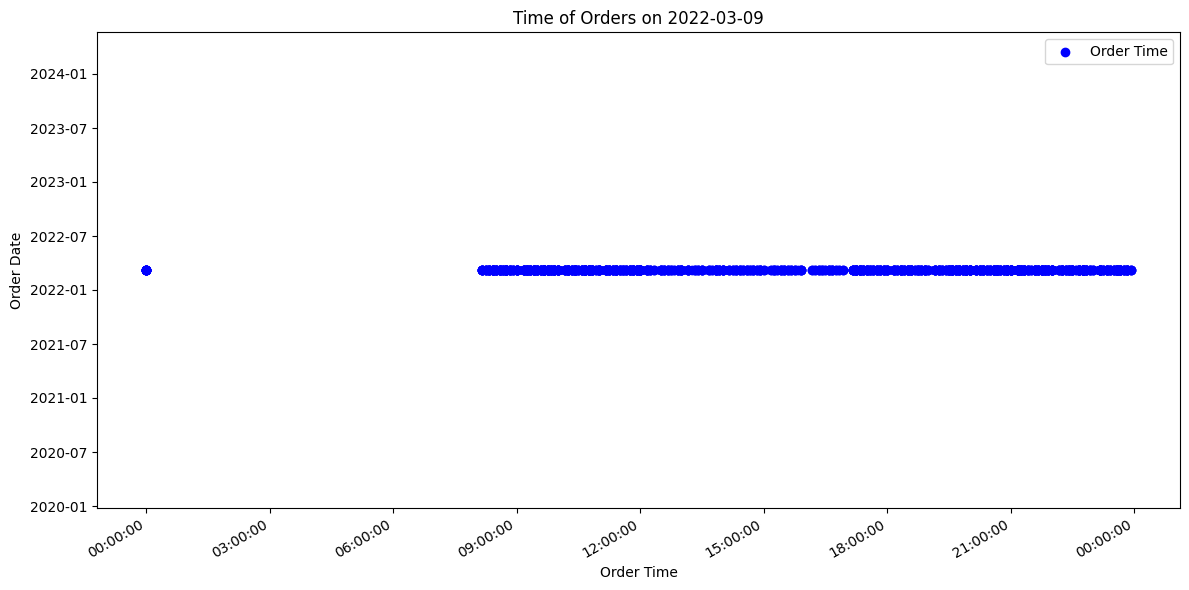

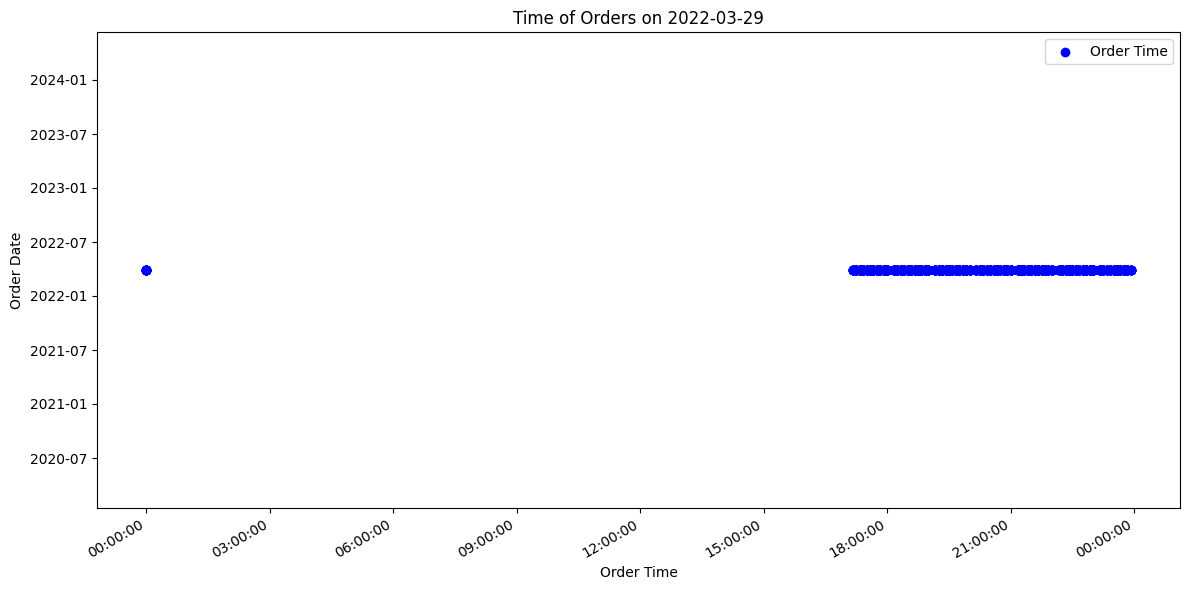

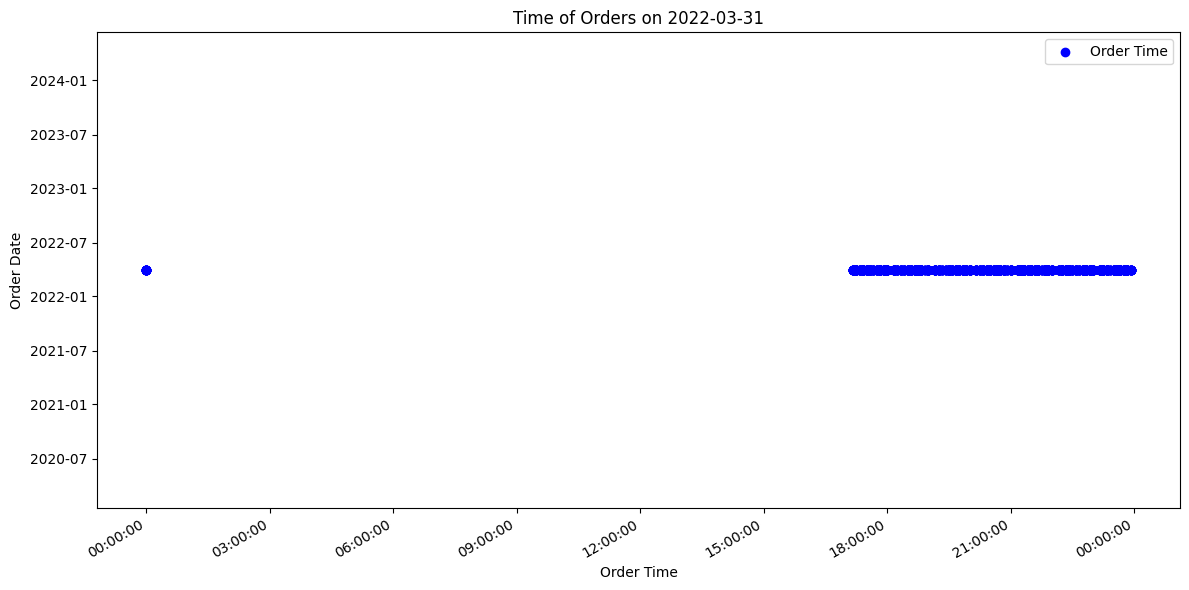

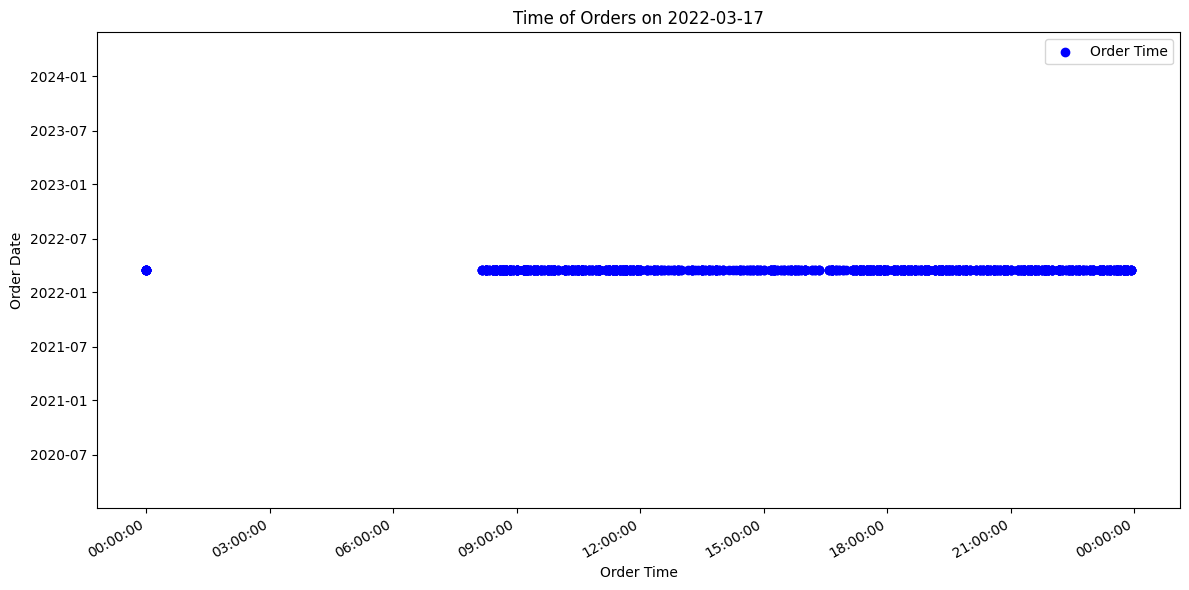

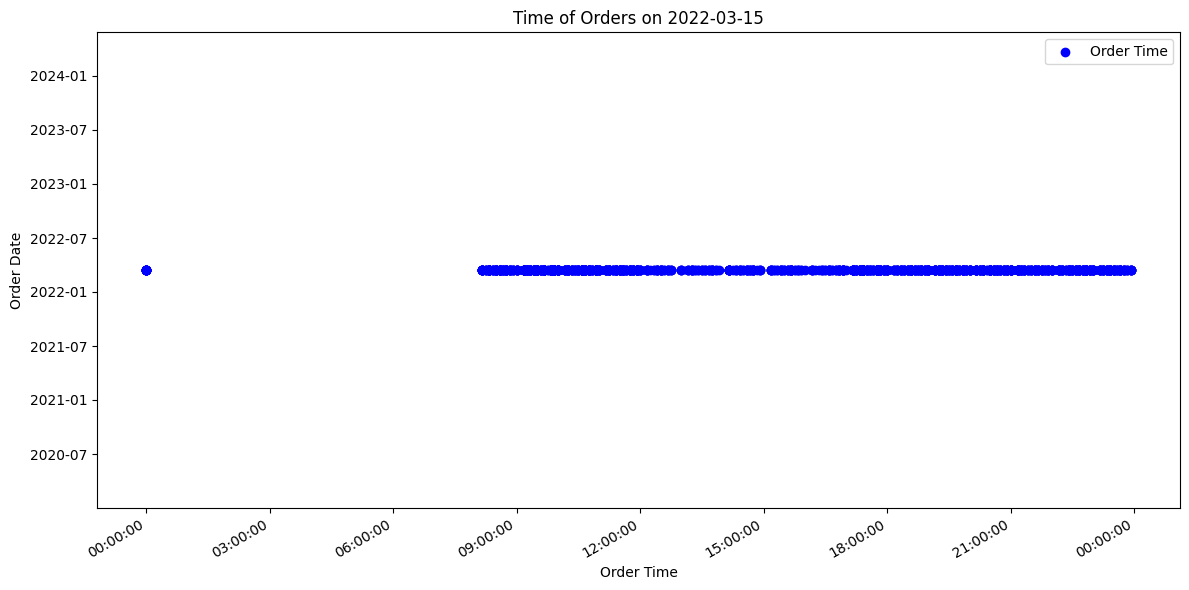

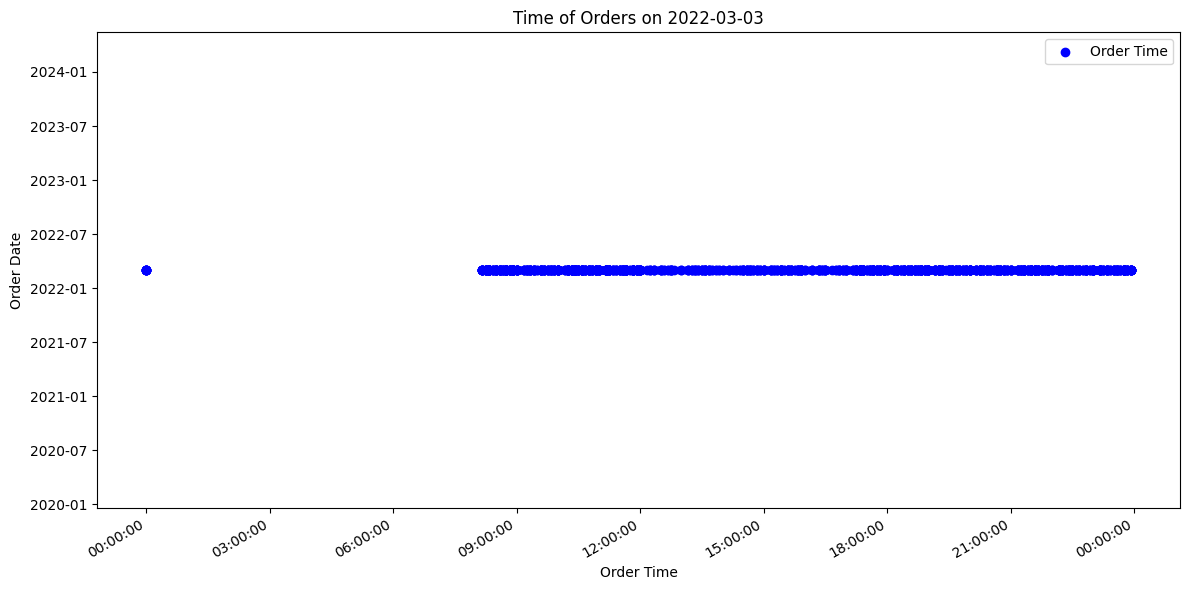

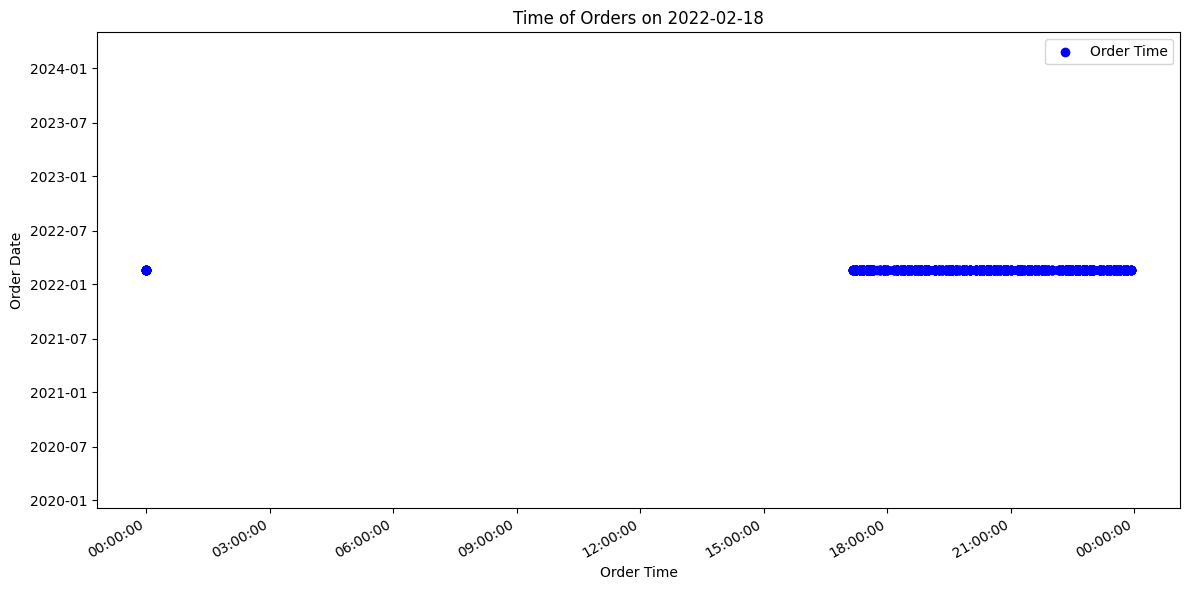

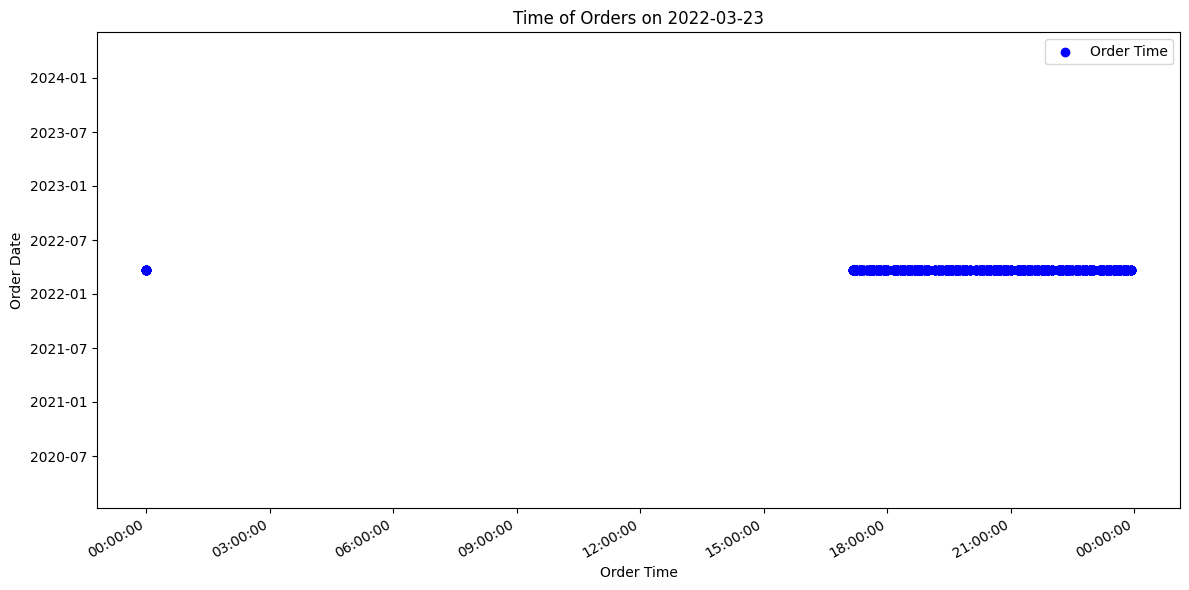

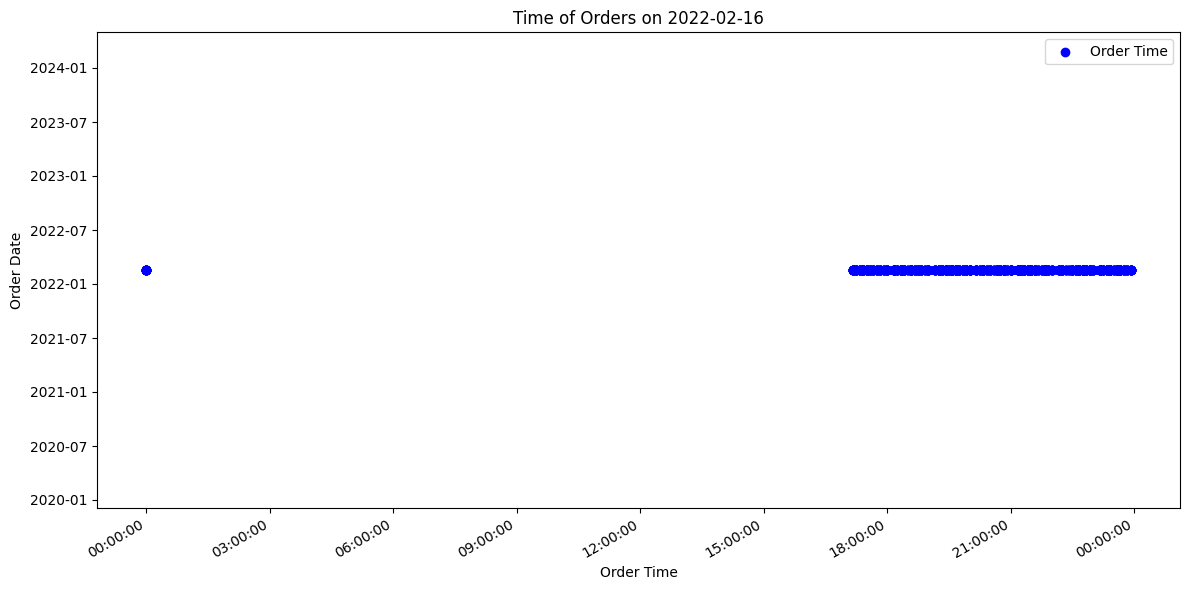

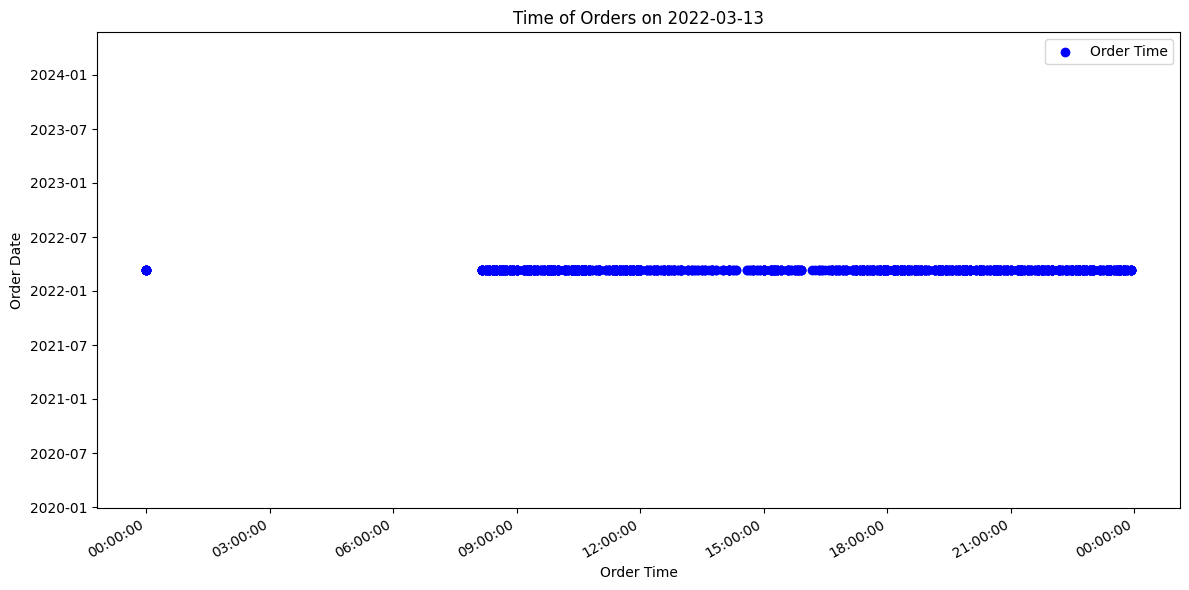

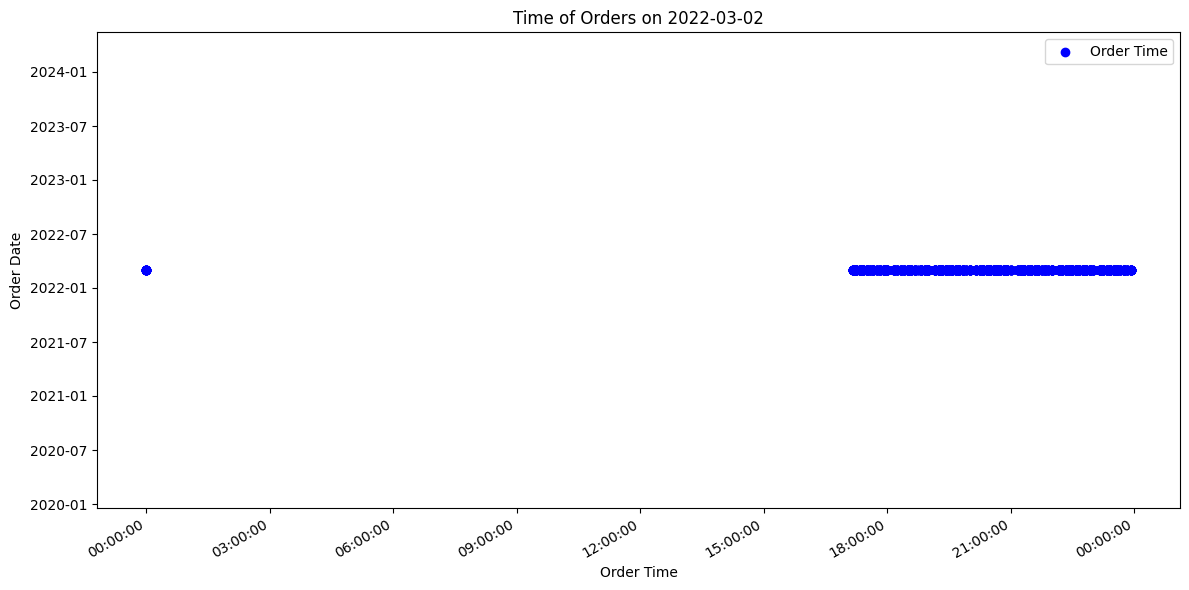

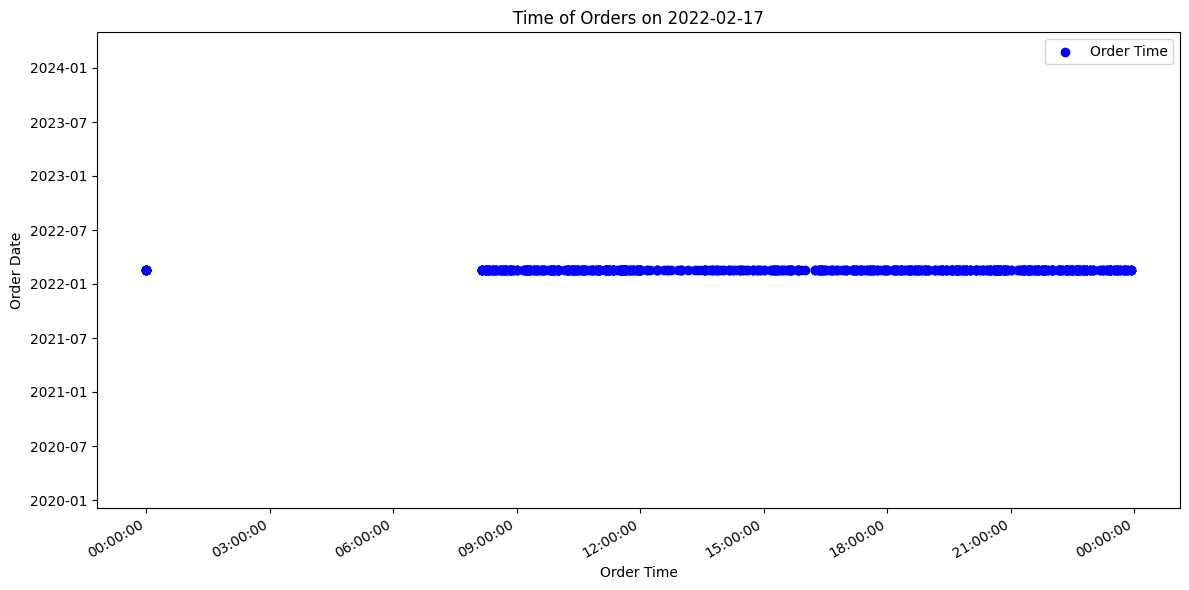

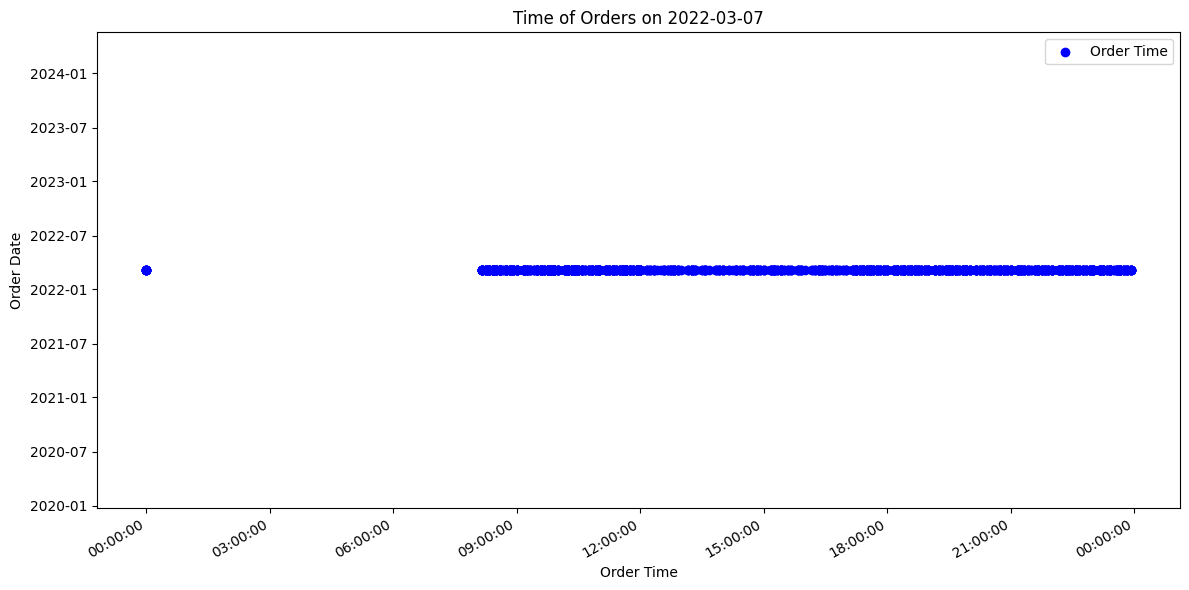

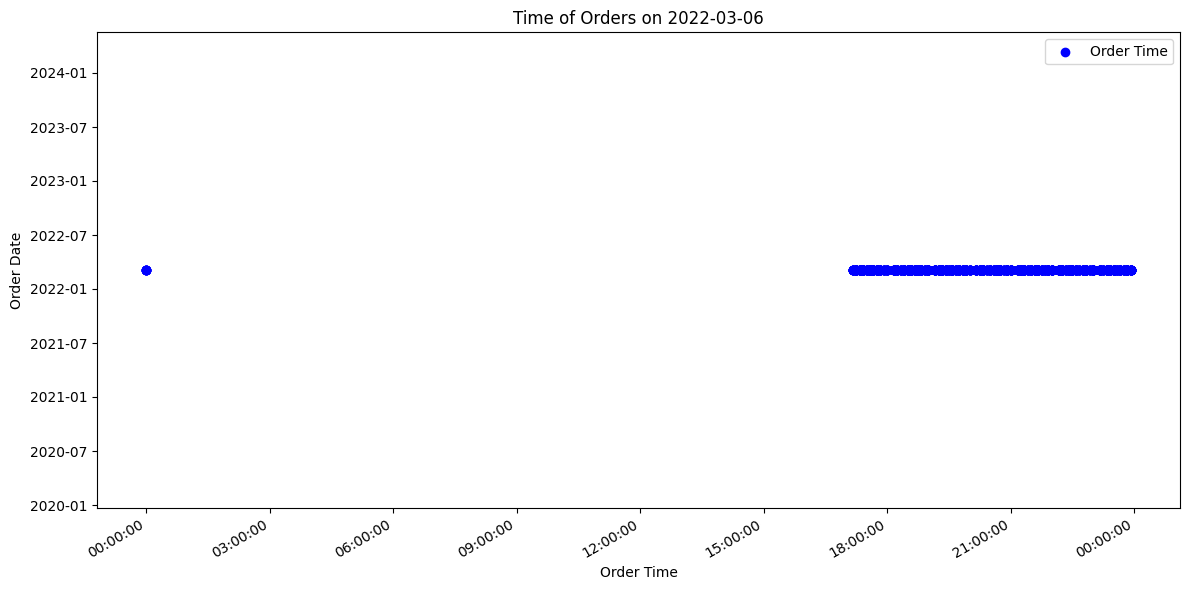

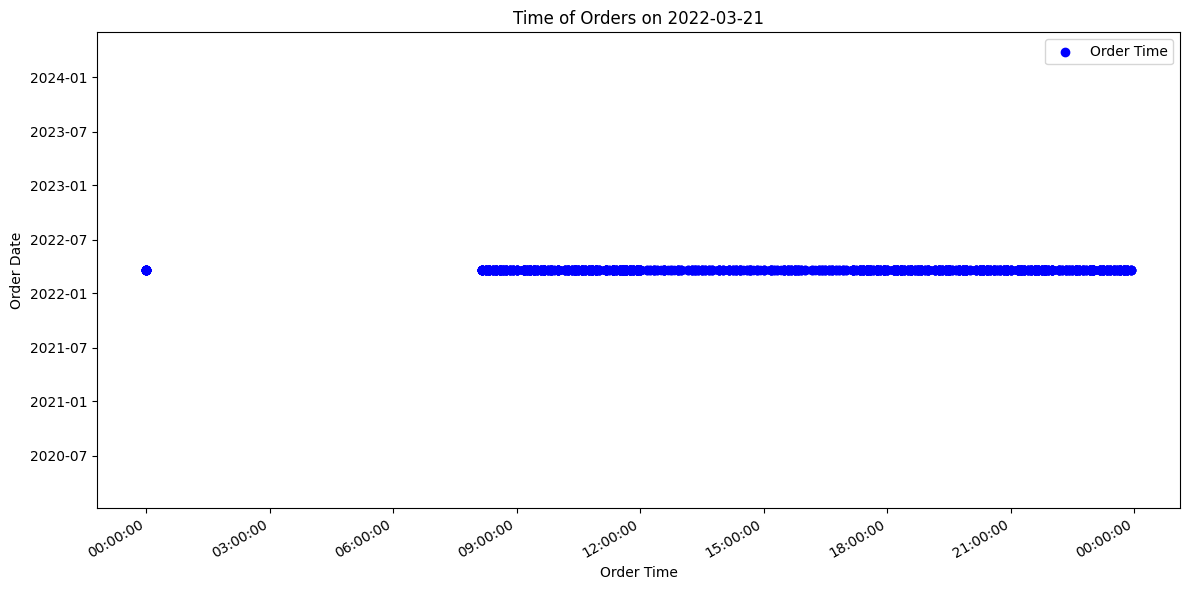

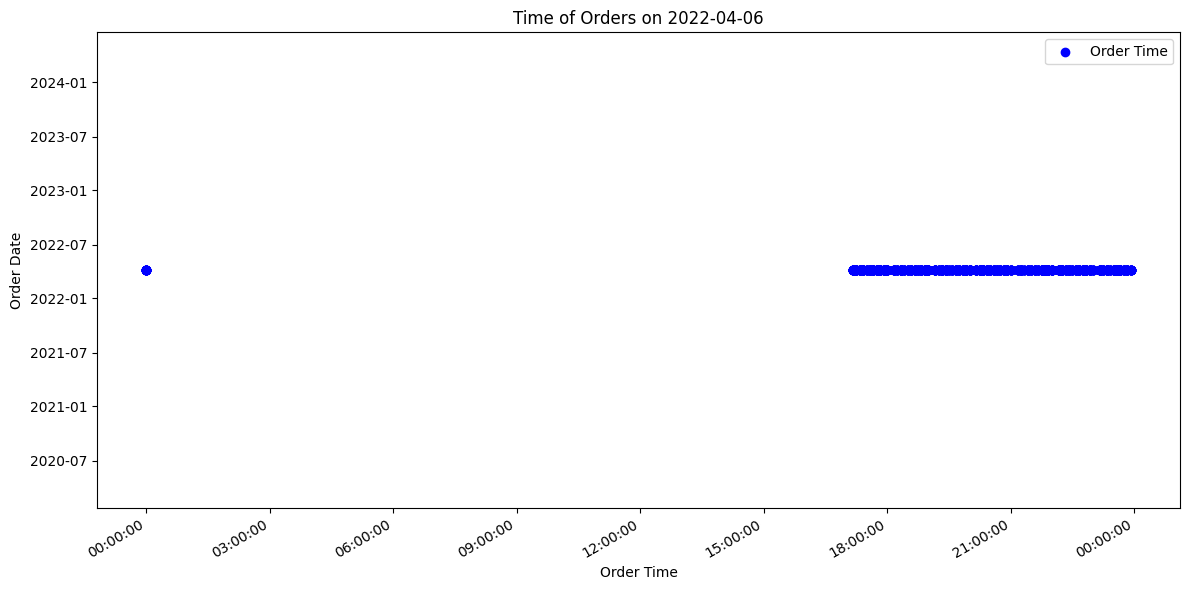

In [ ]:
# Assuming df_sample is your DataFrame and it's already loaded with the data

# Make sure 'Order_Date' and 'Time_Orderd' are converted to datetime objects
df_sample['Order_Date'] = pd.to_datetime(df_sample['Order_Date'], format='%d-%m-%Y')
df_sample['Time_Orderd'] = pd.to_datetime(df_sample['Time_Orderd'], format='%H:%M:%S').dt.time

# Get unique dates from 'Order_Date'
unique_dates = df_sample['Order_Date'].dt.date.unique()

# Plotting
for current_date in unique_dates:
    plt.figure(figsize=(12, 6))
    # Filter rows that match the current_date
    df_date = df_sample[df_sample['Order_Date'].dt.date == current_date]

    # Combine date and time into a single datetime object for plotting
    combined_datetime = [datetime.combine(date, time) for date, time in zip(df_date['Order_Date'], df_date['Time_Orderd'])]

    plt.scatter(combined_datetime, [current_date]*len(combined_datetime), c='blue', label='Order Time')
    plt.gcf().autofmt_xdate()  # Automatically format x-axis labels to fit the dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Set formatter for x-axis to show time only
    plt.xlabel('Order Time')
    plt.ylabel('Order Date')
    plt.title(f'Time of Orders on {current_date}')
    plt.legend()
    plt.tight_layout()

    plt.show()
